In [1]:
import requests, json, re, time, os
import pandas as pd
from pycoingecko import CoinGeckoAPI
import arrow
from glob import glob
from pathlib import Path
# from bs4 import BeautifulSoup'

pd.options.display.max_rows = 999


In [2]:
#create coingecko instance
cg = CoinGeckoAPI()

In [3]:
"""
This project is designed to answer a few questions: 
- How do coins perform in the first 30 days from launch?
- If we put $100 on every single coin at launch, would we be profitable within the first 30 days?
- What are the characteristics of a coin which performs well?
- What are the characteristics of a coin which performs poorly?


We're going to be storing data since ideally this should be something we can dockerize and deploy .

Key functions/features


FIND NEW COINS
- Get all coins and find the ones which have ATLs (basically historical events ) which occured less than 3 years ago
-- Create Blacklist - Store the older coins in a file we can reference. Do this once because old coins will always be old.
"new" coins will automatically be added here 

GET COIN DATA
- pull daily historical data for each coin and store the data in its raw json form
- be fault tolerant because new coins may not have historical data
- pull max date - may need pagination funcitonality
- store in /data/<coin-id>/historic

TRANSFORM & JOIN - ~120 days
- For each coin in /data/
-- Build a 120 day view from launch:
--- pull in data for the max date and add as column to global dataframe
--- write out the dataframe as a csv or json into /reports/120days/120day_report.csv | json
-- Build a lookup table:
--- id = coin name, launch_date = launch date, (zulu)

VISUALISE
- Seaborn?

REPORT
- 30 day forecast from day 1
- 30 day forecast from day 2



HOW TO RUN:

- Gather a list of all coins:
-- get_list_of_all_coins()
- Gather data for blacklist cutoff (if you want to only look at specific date ranges like last 3 years)
-- run build_blacklist()
-- this is slow because the only place I could reliably find early dates was in the coin overview in the ATL (all time low)
-- there is quite a lot of nice other data here though we could use to zero in on high performing coins
- Now pull historical pricing data from each coin we haven't blacklisted
-- get_new_coins() 
-- this will get daily pricing from the maximum date possible. we assume it's the launch
-- this will take time due to coingecko's rate limiting

now we have all the data, we can process it:
- build_table_coin_launch() 
-- will build a table you can use to join to get the starting date of the coin
- build_table_Xdays_from_launch() 
-- will go through all coins we have data for and create a first 'X' days report. Defaults to 120 days

csvs are output to /data/processed_tables


"""

'\nThis project is designed to answer a few questions: \n- How do coins perform in the first 30 days from launch?\n- If we put $100 on every single coin at launch, would we be profitable within the first 30 days?\n- What are the characteristics of a coin which performs well?\n- What are the characteristics of a coin which performs poorly?\n\n\nWe\'re going to be storing data since ideally this should be something we can dockerize and deploy .\n\nKey functions/features\n\n\nFIND NEW COINS\n- Get all coins and find the ones which have ATLs (basically historical events ) which occured less than 3 years ago\n-- Create Blacklist - Store the older coins in a file we can reference. Do this once because old coins will always be old.\n"new" coins will automatically be added here \n\nGET COIN DATA\n- pull daily historical data for each coin and store the data in its raw json form\n- be fault tolerant because new coins may not have historical data\n- pull max date - may need pagination funcitonal

In [ ]:
----------------------------

In [ ]:
###################################
###      Utility functions      ###
###################################

In [3]:
env_coins_directory = "../data/coins/"
env_lists_directory = "../data/lists/"
env_all_coin_details_directory = "../data/lists/all_coin_details/"
env_processed_tables_directory = "../data/processed_tables/"

In [4]:
def create_directory_if_not_in_path(path_of_file):
    """ will create a directory in the path of the file specified if it doesn't exist"""
    directory_of_path = re.sub(r"\/[a-zA-Z0-9_\s\-]+\.json","/",path_of_file)
    Path(directory_of_path).mkdir(parents=True, exist_ok=True)
    
def safe_json_load(path_of_file):
    """abstracting the json load dance to just get the data out"""
    try:
        with open(path_of_file, "r") as json_file:
            return json.load(json_file)
    except Exception as e:
        print(f"unable to load file, {e}")
        raise Exception

        
def safe_json_save(data,path_of_file):
    """abstracting the json save dance to just get the data back"""
    try:
        create_directory_if_not_in_path(path_of_file)
        with open(path_of_file, "w") as json_file:
            json.dump(data, json_file)
            return True
    except Exception as e:
        print(f"unable to save file, {e}")
        raise Exception

def check_file_exists(path_of_file):
    """ tell me if a file exists on the path"""
    return os.path.isfile(path_of_file)
    
def get_files_or_directories_in_path(path,extension=None,directories_only=False):
    """ return a list of all directories in a directory """
    #### MAY NOT BE NEEDED
    
    if extension != None and directories_only ==True:
        raise NameError("Can't have extension and directories only.")
    
    else:
        
    
        glob_query = path

        #check if path or directory
        if directories_only == True:
            glob_query = glob_query + "*/"
        elif extension != None:
            glob_query = glob_query + "*."+extension
        else:
            glob_query = glob_query + "*"
            
        return glob(glob_query)
    
def unix_time_to_iso8601(input_unix_time):
    return arrow.get(input_unix_time)

def get_coin_name_from_path(path):
        return re.sub(r"(^.+\/)|(\.json)","",path)

In [ ]:
###################################
###   Coin specific functions   ###
###################################

In [6]:
def get_list_of_all_coins():
    """ will get a list of all coins from coingecko. Should be run daily. Est size <1mb"""
    
    output_file_path = env_lists_directory+"all_coins.json"
    
    try:
        all_coins = cg.get_coins_list()
    except Exception as e:
        raise Exception
    
    print("completed getting all coins list")
    
    try:
        safe_json_save(all_coins,output_file_path)
        print(f"Successfully saved to{output_file_path}")
    except:
        raise Exception


    print(f"Saved list of coins to {output_file_path}")
    pass

In [ ]:
# def get_ids_from_coins_list():
#     json_coin_list = safe_json_load("env_lists_directory+"all_coins.json)
    
#     coin_list__list = []
#     for eachentry in json_coin_list:
        
        
    

In [8]:
def build_blacklist(cutoff_date="2018-01-01"):
    """ will create a json file with coin names. These will not be processed
    Stored as /data/lists/blacklist.json
    Blacklist is used to skip old coins we don't want to analyze
    """
    
    blacklist = []
    
    def to_epoch(input_date):
        return arrow.get(input_date).format("X")
    
    cutoff_date_epoch = to_epoch(cutoff_date)
    json_coin_list = safe_json_load(env_lists_directory+"all_coins.json")
    
    for each_coin in json_coin_list:
        coin_name = each_coin["id"]
        coin_details = get_coin_details(coin_name)
        
        if coin_details != False:
            coin_atl_date = get_atl_details(coin_name) #may return False on failure
            if coin_atl_date != False:
                if to_epoch(coin_atl_date ) < cutoff_date_epoch:
                    blacklist.append(coin_name)
            
    blacklist_dict = { "blacklist": blacklist }
    
    safe_json_save(blacklist_dict,env_lists_directory+"blacklist.json")
    
    print("blacklist completed")
        

    
    pass

In [16]:
def get_coin_details(coin_name):
    coin_save_path = env_all_coin_details_directory+coin_name+".json"
    if os.path.isfile(coin_save_path): #check if file exists already
        try:
            print(f"{coin_name} information already saved. Using that ")
            return safe_json_load(coin_save_path)

        except Exception as e:
            print(e)
    else:
        try:
            time.sleep(.8) #sleep .5seconds to meet throttling limit
            coin_data = cg.get_coin_by_id(coin_name)
            
            safe_json_save(coin_data,coin_save_path)
            return coin_data
        except Exception as e:
            print(f"looks like we cant query this coin {coin_name}: {e}")
            return False

In [14]:
def get_atl_details(coin_name):
    """get the All Time Low date, which we will use for now as the cutoff / start"""
#     coin_data = cg.get_coin_by_id(coin_name)
#     safe_json_save(coin_data,env_all_coin_details_directory+coin_name+".json")
    try:
        print(f"getting the ATL details for {coin_name}")
        coin_details = safe_json_load(env_all_coin_details_directory+coin_name+".json")
        atl_field = coin_details['market_data']['atl_date']['usd']
        return arrow.get(atl_field)
    except Exception as e:
        print(f"error occurred here. {e}")
        
    
    

In [40]:
def get_new_coins(initial_load =False, overwrite_files=False):  
    """ Will get all coins between now and the last successful load. Initial load will just get all. 
    Will check blacklist and will not query coins if present. 
    Coin data will be stored in /data/coins/<coin_name>/initial_load/  (for initial load)
    Coin data will be stored in /data/coins/<coin_name>/YYYYMMDDTHHmmSS/ (for daily load) - not doing now. need a new param
    Stored as JSON as we recieve it
    Named "YYYYMMDD_<coin_name>.json"
    
    """
    ### Will need env var to specify the last updated, or we can store a log of last processed
    
    
    # load blacklist
    # iterate through items in all coins
    # if coin not in blacklist, get the max coin report
    
    all_coins_list = safe_json_load(env_lists_directory+"all_coins.json")
    blacklist = safe_json_load(env_lists_directory+"blacklist.json")
    
    blacklist_list = []
    for each_blacklist_item in blacklist['blacklist']:
        blacklist_list.append(each_blacklist_item)
    
    for each_coin in all_coins_list:
        
        if each_coin['id'] not in blacklist_list:
            output_coin_path = env_coins_directory+each_coin['id']+".json"
            
            # XXXX CHeck if overwrite_files flag. If false, check if file exists in directory. 
            if overwrite_files == False and check_file_exists(output_coin_path) == False:
                
                time.sleep(1) #limit requests to 1 a second
                try:
                    print(f"getting coin history for {each_coin['id']}")
                    coin_history = cg.get_coin_market_chart_by_id(each_coin['id'],vs_currency="usd",days="max", interval="daily")
                    safe_json_save(coin_history,output_coin_path)
                except Exception as e:
                    print(f"Failed to get history for {each_coin['id']}")
            else:
                print(f"file {each_coin['id']} already saved")


In [5]:
def build_table_Xdays_from_launch(days=120):
    """Will go through the coins we have and build a dataframe of coin opening reports
    from day0 to day 120, relative to the launch date of the coin
    These will be output in a single big assed file like csv / json
    
    """
    
    # I Should normalise to :

    """
    Day | Coin | Price 
    
    Then we can just rely on grouping by

    """
    
    #create df with details. first column "Da"
    
    df = pd.DataFrame(columns = ["day_number","coin_id", "coin_price"])  #pandas uses 1 as start 
    
    
#     return 0
    # list(range(11, 17))
    
    #iterate through every coin in coin directory
    #safe load
    #check for length of list and if less than days, get the max then null the rest
    #for each in range 0-days(or max if less than days)
    #append to a list
    #once completed, 
    
    def create_list_for_coin(coin,days=days):
        """ Create a list with the days 0-maxdays listed, coin name """
        
        day_numbers = list(range(0, days))
        coin_df = pd.DataFrame(day_numbers, columns=["day_number"])
        coin_df["coin_id"] = coin
        
        return coin_df
    
    
    coin_directory_contents = get_files_or_directories_in_path(env_coins_directory,extension="json")
    
    for each_coin_file in coin_directory_contents:    
        coin_content = safe_json_load(each_coin_file)
        coin_days = days
        coin_pricing_column = []
        coin_name = get_coin_name_from_path(each_coin_file)
        coin_days_dif = 0
        
        print(f"starting on {coin_name}")
        
        #create a list 
        
        
        
        length_of_data = len(coin_content['prices'])
        if coin_days > length_of_data:
            coin_days = length_of_data
            coin_days_dif = days-length_of_data
            print(f"different sized days: {coin_days_dif}")
        
        for day_number in range(0,coin_days):
            coin_pricing_column.append(coin_content['prices'][day_number][1]) #append price at day
            
        if coin_days_dif != 0:
            #extend the list so all are same length for dataframe
            for day_number_empty in range(0,coin_days_dif):
                coin_pricing_column.append(None)
            
        coin_df = create_list_for_coin(coin_name,days)
        coin_df["coin_price"] = coin_pricing_column
#         coin_df.reset_index()
        
#         display(coin_df)
        
        df = df.append(coin_df, ignore_index=True)
#         df[coin_name] = coin_pricing_column
        
        print(f"added {coin_name} to dataframe")
#         print(df)

            
#     display(df.head())

    df.to_csv(env_processed_tables_directory+f"coin_day_launch_report{days}_normalised.csv", index=False)
    print("completed outputting coin pricing range from launch table.")
    
    print(df)
    
    
    pass

In [80]:
def build_table_coin_launch():
    """Will build a table which has the coin name and launch date (max date listed)
    This will allow us to split coins into specific bins eg. "2021 bull market"
    """
    coin_directory = get_files_or_directories_in_path(env_coins_directory,extension="json")
    
    coin_list = []
    
#     def get_coin_name_from_path(path):
#         return re.sub(r"(^.+\/)|(\.json)","",path)
    
    
    
    for each_coin_file in coin_directory:
        coin_content = safe_json_load(each_coin_file)
        coin_name = get_coin_name_from_path(each_coin_file)
        
        try:
            coin_first_date = unix_time_to_iso8601(coin_content["prices"][0][0])
        except Exception as e:
            raise ValueError(f"Coin {coin_name} doesn't have a start date. Maybe wait a bit for new data")
            coin_first_date = None
        
        
        coin_list.append([coin_name,coin_first_date])
        #name of coin = name of file
        #each_coin_file['prices'][0] is the first price at opening
        
    df = pd.DataFrame(coin_list,columns=["coin_id","first_date"])
    
    df.to_csv(env_processed_tables_directory+"coin_details.csv", index=False)
    print("completed outputting coin details table.")

In [ ]:
# debugging and scratchpad below

In [71]:
build_table_coin_launch()

In [8]:
build_table_Xdays_from_launch(days=365)

starting on goldblock
added goldblock to dataframe
starting on arth
different sized days: 241
added arth to dataframe
starting on interest-bearing-dpi
different sized days: 318
added interest-bearing-dpi to dataframe
starting on dexa-coin
added dexa-coin to dataframe
starting on californium
added californium to dataframe
starting on able
added able to dataframe
starting on intelligent-investment-chain
added intelligent-investment-chain to dataframe
starting on marginswap
different sized days: 262
added marginswap to dataframe
starting on astro
added astro to dataframe
starting on shibaken-finance
different sized days: 353
added shibaken-finance to dataframe
starting on nebulas
added nebulas to dataframe
starting on truegbp
different sized days: 175
added truegbp to dataframe
starting on lbrl
different sized days: 173
added lbrl to dataframe
starting on zrcoin
added zrcoin to dataframe
starting on defit
different sized days: 320
added defit to dataframe
starting on hxro
added hxro to da

added anchor to dataframe
starting on axis-defi
different sized days: 91
added axis-defi to dataframe
starting on mad-bull-token
different sized days: 360
added mad-bull-token to dataframe
starting on cybereits
added cybereits to dataframe
starting on ardcoin
added ardcoin to dataframe
starting on weather-finance
different sized days: 351
added weather-finance to dataframe
starting on bitsou
added bitsou to dataframe
starting on ether-1
added ether-1 to dataframe
starting on dai
added dai to dataframe
starting on orlycoin
added orlycoin to dataframe
starting on sombe
added sombe to dataframe
starting on 3x-short-eos-token
added 3x-short-eos-token to dataframe
starting on basiscoin-share
different sized days: 229
added basiscoin-share to dataframe
starting on bitcoin-bep2
added bitcoin-bep2 to dataframe
starting on blockchain-of-hash-power
added blockchain-of-hash-power to dataframe
starting on invox-finance
different sized days: 138
added invox-finance to dataframe
starting on premia
d

added rover-inu to dataframe
starting on relianz
added relianz to dataframe
starting on own-token
different sized days: 81
added own-token to dataframe
starting on yfi-business
different sized days: 163
added yfi-business to dataframe
starting on crypto-village-accelerator
added crypto-village-accelerator to dataframe
starting on color
added color to dataframe
starting on yearn-finance-bit
different sized days: 130
added yearn-finance-bit to dataframe
starting on super8
added super8 to dataframe
starting on yftether
different sized days: 239
added yftether to dataframe
starting on hubdao
different sized days: 160
added hubdao to dataframe
starting on wom-token
added wom-token to dataframe
starting on 3x-long-tether-token
different sized days: 147
added 3x-long-tether-token to dataframe
starting on hyper-pay
added hyper-pay to dataframe
starting on cream-eth2
different sized days: 228
added cream-eth2 to dataframe
starting on most-protocol
different sized days: 268
added most-protocol t

added markyt to dataframe
starting on zcnox-coin
different sized days: 183
added zcnox-coin to dataframe
starting on ycash
added ycash to dataframe
starting on privacy
different sized days: 205
added privacy to dataframe
starting on unido-ep
different sized days: 284
added unido-ep to dataframe
starting on dubaicoin-dbix
added dubaicoin-dbix to dataframe
starting on soteria
different sized days: 255
added soteria to dataframe
starting on global-china-cash
added global-china-cash to dataframe
starting on daofi
different sized days: 144
added daofi to dataframe
starting on algopainter
different sized days: 349
added algopainter to dataframe
starting on benchmark-protocol
different sized days: 187
added benchmark-protocol to dataframe
starting on cryptorg-token
different sized days: 18
added cryptorg-token to dataframe
starting on bribe-token
different sized days: 336
added bribe-token to dataframe
starting on playgroundz
added playgroundz to dataframe
starting on harcomia
added harcomia 

added contentos to dataframe
starting on feeder-finance
different sized days: 345
added feeder-finance to dataframe
starting on carillonium
different sized days: 334
added carillonium to dataframe
starting on yas
different sized days: 74
added yas to dataframe
starting on metal
added metal to dataframe
starting on near
different sized days: 145
added near to dataframe
starting on global-hash-power
added global-hash-power to dataframe
starting on stronghold
different sized days: 340
added stronghold to dataframe
starting on unfederalreserve
different sized days: 159
added unfederalreserve to dataframe
starting on defini
different sized days: 314
added defini to dataframe
starting on 3x-long-kyber-network-token
different sized days: 76
added 3x-long-kyber-network-token to dataframe
starting on aeron
added aeron to dataframe
starting on orb-v2
different sized days: 261
added orb-v2 to dataframe
starting on sorachancoin
added sorachancoin to dataframe
starting on hathor
different sized day

added shuffle-monster to dataframe
starting on iridium
added iridium to dataframe
starting on bitfresh
different sized days: 339
added bitfresh to dataframe
starting on bridge-finance
different sized days: 222
added bridge-finance to dataframe
starting on lockchain
added lockchain to dataframe
starting on geodb
added geodb to dataframe
starting on maxonrow
added maxonrow to dataframe
starting on largo-coin
added largo-coin to dataframe
starting on aave-tusd-v1
different sized days: 34
added aave-tusd-v1 to dataframe
starting on complus-network
different sized days: 364
added complus-network to dataframe
starting on xazab
different sized days: 327
added xazab to dataframe
starting on ixtz
different sized days: 31
added ixtz to dataframe
starting on zucoinchain
added zucoinchain to dataframe
starting on yfilend-finance
different sized days: 125
added yfilend-finance to dataframe
starting on og-fan-token
different sized days: 31
added og-fan-token to dataframe
starting on hope-token
diffe

starting on hash-pot
added hash-pot to dataframe
starting on eos-btc
added eos-btc to dataframe
starting on gemstone
different sized days: 304
added gemstone to dataframe
starting on echosoracoin
added echosoracoin to dataframe
starting on eth-26-ma-crossover-yield-ii
different sized days: 81
added eth-26-ma-crossover-yield-ii to dataframe
starting on pnetwork
different sized days: 28
added pnetwork to dataframe
starting on nusd
added nusd to dataframe
starting on crowd-one
added crowd-one to dataframe
starting on speedcash
added speedcash to dataframe
starting on philscurrency
added philscurrency to dataframe
starting on axel
added axel to dataframe
starting on insureum
added insureum to dataframe
starting on vegawallet-token
added vegawallet-token to dataframe
starting on cmitcoin
added cmitcoin to dataframe
starting on monero-classic-xmc
added monero-classic-xmc to dataframe
starting on milfies
different sized days: 288
added milfies to dataframe
starting on casinocoin
added casinoc

added protocol-finance to dataframe
starting on universal-euro
different sized days: 103
added universal-euro to dataframe
starting on eth-link-price-action-candlestick-set
added eth-link-price-action-candlestick-set to dataframe
starting on mdsquare
added mdsquare to dataframe
starting on mifty-swap
different sized days: 362
added mifty-swap to dataframe
starting on cherry
different sized days: 84
added cherry to dataframe
starting on ryo
added ryo to dataframe
starting on kine-protocol
different sized days: 293
added kine-protocol to dataframe
starting on wall-street-bets-dapp
different sized days: 341
added wall-street-bets-dapp to dataframe
starting on izichain
added izichain to dataframe
starting on oracle-system
different sized days: 118
added oracle-system to dataframe
starting on life-token
different sized days: 346
added life-token to dataframe
starting on renbtc
different sized days: 17
added renbtc to dataframe
starting on andes-coin
added andes-coin to dataframe
starting on

added aitheon to dataframe
starting on wownero
added wownero to dataframe
starting on sierracoin
added sierracoin to dataframe
starting on idle-usdc-yield
different sized days: 78
added idle-usdc-yield to dataframe
starting on melalie
different sized days: 340
added melalie to dataframe
starting on vidulum
added vidulum to dataframe
starting on welltrado
added welltrado to dataframe
starting on solace-coin
added solace-coin to dataframe
starting on kava
added kava to dataframe
starting on iqeon
added iqeon to dataframe
starting on ponzicoin
added ponzicoin to dataframe
starting on newton-project
added newton-project to dataframe
starting on joos-protocol
added joos-protocol to dataframe
starting on yep-coin
different sized days: 246
added yep-coin to dataframe
starting on circleex
different sized days: 286
added circleex to dataframe
starting on rheaprotocol
added rheaprotocol to dataframe
starting on 3x-long-stellar-token
different sized days: 202
added 3x-long-stellar-token to datafr

added money-cash-miner to dataframe
starting on metronome
added metronome to dataframe
starting on spiderdao
different sized days: 206
added spiderdao to dataframe
starting on encocoin
added encocoin to dataframe
starting on wrapped-atromg8
different sized days: 345
added wrapped-atromg8 to dataframe
starting on portion
different sized days: 234
added portion to dataframe
starting on coinanalyst
different sized days: 70
added coinanalyst to dataframe
starting on fei-protocol
different sized days: 316
added fei-protocol to dataframe
starting on homeros
added homeros to dataframe
starting on philosafe-token
added philosafe-token to dataframe
starting on ammyi-coin
different sized days: 304
added ammyi-coin to dataframe
starting on bitenium-token
different sized days: 314
added bitenium-token to dataframe
starting on pibble
added pibble to dataframe
starting on filecoin-iou
added filecoin-iou to dataframe
starting on realtoken-16200-fullerton-avenue-detroit-mi
different sized days: 175
ad

added defy-farm to dataframe
starting on russian-miner-coin
added russian-miner-coin to dataframe
starting on swerve-dao
different sized days: 105
added swerve-dao to dataframe
starting on arcs
added arcs to dataframe
starting on credits
added credits to dataframe
starting on zom
different sized days: 113
added zom to dataframe
starting on apeusd-link-synthetic-usd-dec-2021
different sized days: 364
added apeusd-link-synthetic-usd-dec-2021 to dataframe
starting on zent-cash
added zent-cash to dataframe
starting on degen-arts
different sized days: 338
added degen-arts to dataframe
starting on red
added red to dataframe
starting on kilimanjaro
different sized days: 336
added kilimanjaro to dataframe
starting on lumeneo
added lumeneo to dataframe
starting on bata
added bata to dataframe
starting on dextrust
different sized days: 107
added dextrust to dataframe
starting on dogemoon
different sized days: 350
added dogemoon to dataframe
starting on sustainable-energy-token
different sized da

added dlike to dataframe
starting on wenlambo
different sized days: 360
added wenlambo to dataframe
starting on xdna
added xdna to dataframe
starting on deligence
added deligence to dataframe
starting on rupee
added rupee to dataframe
starting on venus-busd
different sized days: 364
added venus-busd to dataframe
starting on gspi
different sized days: 293
added gspi to dataframe
starting on 0-5x-long-bitcoin-token
different sized days: 179
added 0-5x-long-bitcoin-token to dataframe
starting on hplus
different sized days: 260
added hplus to dataframe
starting on bitcratic-revenue
different sized days: 181
added bitcratic-revenue to dataframe
starting on mirrored-ishares-gold-trust
different sized days: 236
added mirrored-ishares-gold-trust to dataframe
starting on endor
added endor to dataframe
starting on pixie-coin
added pixie-coin to dataframe
starting on deracoin
different sized days: 349
added deracoin to dataframe
starting on tessla-coin
different sized days: 182
added tessla-coin 

added artax to dataframe
starting on moonswap
different sized days: 113
added moonswap to dataframe
starting on couchain
added couchain to dataframe
starting on aced
added aced to dataframe
starting on infinity-economics
added infinity-economics to dataframe
starting on devery
added devery to dataframe
starting on fireball
different sized days: 72
added fireball to dataframe
starting on convergence
different sized days: 307
added convergence to dataframe
starting on xenios
added xenios to dataframe
starting on btc-2x-flexible-leverage-index
different sized days: 354
added btc-2x-flexible-leverage-index to dataframe
starting on ims-wallet
different sized days: 258
added ims-wallet to dataframe
starting on anti-lockdown
different sized days: 347
added anti-lockdown to dataframe
starting on decentralized-machine-learning
added decentralized-machine-learning to dataframe
starting on hygenercoin
added hygenercoin to dataframe
starting on yetiswap
different sized days: 325
added yetiswap to 

starting on masternet
added masternet to dataframe
starting on young-boys-fan-token
different sized days: 249
added young-boys-fan-token to dataframe
starting on litecoin-finance
added litecoin-finance to dataframe
starting on dudgx
added dudgx to dataframe
starting on rozeus
added rozeus to dataframe
starting on 3x-short-balancer-token
different sized days: 76
added 3x-short-balancer-token to dataframe
starting on mirrored-google
different sized days: 236
added mirrored-google to dataframe
starting on axioms
different sized days: 133
added axioms to dataframe
starting on casper-network
different sized days: 355
added casper-network to dataframe
starting on bitriver
different sized days: 340
added bitriver to dataframe
starting on undo-token
different sized days: 358
added undo-token to dataframe
starting on mobilego
added mobilego to dataframe
starting on tadpole-finance
different sized days: 178
added tadpole-finance to dataframe
starting on videocoin
added videocoin to dataframe
sta

added wheat-token to dataframe
starting on bellcoin
added bellcoin to dataframe
starting on coinstox
different sized days: 297
added coinstox to dataframe
starting on pegazus-finance
different sized days: 361
added pegazus-finance to dataframe
starting on papa-shiba
different sized days: 356
added papa-shiba to dataframe
starting on goldpieces
added goldpieces to dataframe
starting on gamercoin
different sized days: 321
added gamercoin to dataframe
starting on unizen
different sized days: 329
added unizen to dataframe
starting on saffron-finance
different sized days: 176
added saffron-finance to dataframe
starting on growth-defi
different sized days: 96
added growth-defi to dataframe
starting on save-token-us
added save-token-us to dataframe
starting on mtblock
added mtblock to dataframe
starting on paycent
added paycent to dataframe
starting on seth
added seth to dataframe
starting on bytus
added bytus to dataframe
starting on mchain
added mchain to dataframe
starting on idle-tusd-yie

added spritzcoin to dataframe
starting on argenpeso
different sized days: 314
added argenpeso to dataframe
starting on amix
different sized days: 93
added amix to dataframe
starting on beetle-coin
added beetle-coin to dataframe
starting on yieldwatch
different sized days: 285
added yieldwatch to dataframe
starting on fusible
different sized days: 287
added fusible to dataframe
starting on wings
added wings to dataframe
starting on zenzo
added zenzo to dataframe
starting on smart-trade-coin
different sized days: 354
added smart-trade-coin to dataframe
starting on smart-mfg
added smart-mfg to dataframe
starting on purple-butterfly-trading
added purple-butterfly-trading to dataframe
starting on datakyc
added datakyc to dataframe
starting on belugaswap
different sized days: 256
added belugaswap to dataframe
starting on tokentuber
added tokentuber to dataframe
starting on yvboost
different sized days: 344
added yvboost to dataframe
starting on rate3
added rate3 to dataframe
starting on 6ix9

added powerbalt to dataframe
starting on bountymarketcap
different sized days: 216
added bountymarketcap to dataframe
starting on plutopepe
different sized days: 355
added plutopepe to dataframe
starting on chad-link-set
different sized days: 93
added chad-link-set to dataframe
starting on wecoown
different sized days: 305
added wecoown to dataframe
starting on kaaso
added kaaso to dataframe
starting on kuaitoken
added kuaitoken to dataframe
starting on gadoshi
different sized days: 278
added gadoshi to dataframe
starting on tokok
added tokok to dataframe
starting on bitball-treasure
added bitball-treasure to dataframe
starting on versoview
different sized days: 206
added versoview to dataframe
starting on base-protocol
different sized days: 193
added base-protocol to dataframe
starting on dav
added dav to dataframe
starting on feg-token-bsc
different sized days: 308
added feg-token-bsc to dataframe
starting on infinite-ricks
different sized days: 28
added infinite-ricks to dataframe
s

added innovation-blockchain-payment to dataframe
starting on metadium
added metadium to dataframe
starting on sheesh-it-is-bussin-bussin
different sized days: 356
added sheesh-it-is-bussin-bussin to dataframe
starting on crosspad
different sized days: 346
added crosspad to dataframe
starting on storichain-token
added storichain-token to dataframe
starting on qitmeer
added qitmeer to dataframe
starting on organix
different sized days: 98
added organix to dataframe
starting on coweye
added coweye to dataframe
starting on axpire
added axpire to dataframe
starting on regiment-finance
different sized days: 348
added regiment-finance to dataframe
starting on spindle
added spindle to dataframe
starting on elysian
added elysian to dataframe
starting on syntheify-token
different sized days: 364
added syntheify-token to dataframe
starting on printer-finance
different sized days: 257
added printer-finance to dataframe
starting on moneta
added moneta to dataframe
starting on investin
different siz

added bankroll-vault to dataframe
starting on poc-chain
added poc-chain to dataframe
starting on dfohub
added dfohub to dataframe
starting on penguin-finance
different sized days: 318
added penguin-finance to dataframe
starting on creed-finance
different sized days: 212
added creed-finance to dataframe
starting on celer-network
added celer-network to dataframe
starting on poet
added poet to dataframe
starting on ddmcoin
added ddmcoin to dataframe
starting on data-saver-coin
added data-saver-coin to dataframe
starting on healing-plus
different sized days: 60
added healing-plus to dataframe
starting on dex-trade-coin
different sized days: 340
added dex-trade-coin to dataframe
starting on bitcoinote
added bitcoinote to dataframe
starting on agavecoin
added agavecoin to dataframe
starting on vault12
added vault12 to dataframe
starting on bast
different sized days: 145
added bast to dataframe
starting on exchange-union
added exchange-union to dataframe
starting on hodlearn
different sized d

added dukascoin to dataframe
starting on blockbase
different sized days: 58
added blockbase to dataframe
starting on strayacoin
added strayacoin to dataframe
starting on ape-punk
different sized days: 307
added ape-punk to dataframe
starting on mimosa
different sized days: 283
added mimosa to dataframe
starting on game
added game to dataframe
starting on auroratoken
different sized days: 353
added auroratoken to dataframe
starting on b21
different sized days: 213
added b21 to dataframe
starting on davinci-coin
added davinci-coin to dataframe
starting on curryswap
different sized days: 237
added curryswap to dataframe
starting on utrum
added utrum to dataframe
starting on coinzo-token
added coinzo-token to dataframe
starting on boliecoin
different sized days: 264
added boliecoin to dataframe
starting on hidden-coin
added hidden-coin to dataframe
starting on whiterockcasino
different sized days: 164
added whiterockcasino to dataframe
starting on neko-network
different sized days: 362
add

added karbo to dataframe
starting on pop-chest-token
added pop-chest-token to dataframe
starting on 3x-short-dragon-index-token
added 3x-short-dragon-index-token to dataframe
starting on cryptohashtank-coin
added cryptohashtank-coin to dataframe
starting on guider
added guider to dataframe
starting on bifi
different sized days: 238
added bifi to dataframe
starting on shiba-inu
different sized days: 85
added shiba-inu to dataframe
starting on tomochain
added tomochain to dataframe
starting on tetris
different sized days: 356
added tetris to dataframe
starting on cumrocket
different sized days: 342
added cumrocket to dataframe
starting on milk-token
different sized days: 348
added milk-token to dataframe
starting on piasa
added piasa to dataframe
starting on obr
different sized days: 181
added obr to dataframe
starting on vangold-token
different sized days: 340
added vangold-token to dataframe
starting on bliss-2
different sized days: 254
added bliss-2 to dataframe
starting on winsor-tok

added yfos-finance to dataframe
starting on saturna
different sized days: 358
added saturna to dataframe
starting on finance-vote
different sized days: 184
added finance-vote to dataframe
starting on giletjaunecoin
added giletjaunecoin to dataframe
starting on nestree
added nestree to dataframe
starting on binance-agile-set-dollar
different sized days: 294
added binance-agile-set-dollar to dataframe
starting on work-quest
different sized days: 317
added work-quest to dataframe
starting on paxex
added paxex to dataframe
starting on lua-token
different sized days: 129
added lua-token to dataframe
starting on project-pai
added project-pai to dataframe
starting on mogul-productions
different sized days: 336
added mogul-productions to dataframe
starting on defhold
different sized days: 182
added defhold to dataframe
starting on knoxfs
different sized days: 92
added knoxfs to dataframe
starting on true-pnl
different sized days: 364
added true-pnl to dataframe
starting on b-one-payment
added 

added quai-dao to dataframe
starting on robo-token
different sized days: 313
added robo-token to dataframe
starting on dequant
added dequant to dataframe
starting on stabinol
different sized days: 297
added stabinol to dataframe
starting on tama-egg-niftygotchi
different sized days: 193
added tama-egg-niftygotchi to dataframe
starting on timers
different sized days: 146
added timers to dataframe
starting on quish-coin
different sized days: 135
added quish-coin to dataframe
starting on ahatoken
different sized days: 87
added ahatoken to dataframe
starting on tesra
added tesra to dataframe
starting on twinci
different sized days: 332
added twinci to dataframe
starting on mustangtoken
different sized days: 352
added mustangtoken to dataframe
starting on digitex-futures-exchange
added digitex-futures-exchange to dataframe
starting on bitball
added bitball to dataframe
starting on trinity-bsc
different sized days: 289
added trinity-bsc to dataframe
starting on asla
different sized days: 241

added unimex-network to dataframe
starting on owndata
added owndata to dataframe
starting on coshi-inu
different sized days: 347
added coshi-inu to dataframe
starting on ozziecoin
added ozziecoin to dataframe
starting on mixty-finance
different sized days: 315
added mixty-finance to dataframe
starting on yd-btc-jun21
different sized days: 326
added yd-btc-jun21 to dataframe
starting on saferune
different sized days: 349
added saferune to dataframe
starting on classicbitcoin
added classicbitcoin to dataframe
starting on terrausd
different sized days: 132
added terrausd to dataframe
starting on guapcoin
different sized days: 17
added guapcoin to dataframe
starting on rxc
different sized days: 290
added rxc to dataframe
starting on dreamcoin
added dreamcoin to dataframe
starting on dtube-coin
different sized days: 189
added dtube-coin to dataframe
starting on dapplinks
added dapplinks to dataframe
starting on temtem
added temtem to dataframe
starting on quasarcoin
added quasarcoin to data

added trust-wallet-token to dataframe
starting on voltium
different sized days: 364
added voltium to dataframe
starting on unitydao
different sized days: 189
added unitydao to dataframe
starting on rocket-fund
added rocket-fund to dataframe
starting on wrapped-celo
different sized days: 228
added wrapped-celo to dataframe
starting on promotionchain
added promotionchain to dataframe
starting on fire-protocol
different sized days: 220
added fire-protocol to dataframe
starting on basketcoin
different sized days: 326
added basketcoin to dataframe
starting on chesscoin-0-32
different sized days: 158
added chesscoin-0-32 to dataframe
starting on coral-swap
different sized days: 167
added coral-swap to dataframe
starting on skycoin
added skycoin to dataframe
starting on latteswap
different sized days: 362
added latteswap to dataframe
starting on dark-matter
different sized days: 289
added dark-matter to dataframe
starting on unicly-mooncats-collection
different sized days: 363
added unicly-mo

added waifu-token to dataframe
starting on brainaut-defi
different sized days: 334
added brainaut-defi to dataframe
starting on relayer-network-2
different sized days: 283
added relayer-network-2 to dataframe
starting on kmushicoin
added kmushicoin to dataframe
starting on chonk
different sized days: 153
added chonk to dataframe
starting on digital-euro
added digital-euro to dataframe
starting on 1x-short-privacy-index-token
different sized days: 302
added 1x-short-privacy-index-token to dataframe
starting on rentible
different sized days: 345
added rentible to dataframe
starting on btc-network-demand-set-ii
added btc-network-demand-set-ii to dataframe
starting on prot
added prot to dataframe
starting on rutheneum
different sized days: 30
added rutheneum to dataframe
starting on bscview
different sized days: 294
added bscview to dataframe
starting on abosom
different sized days: 349
added abosom to dataframe
starting on sgoog
different sized days: 359
added sgoog to dataframe
starting 

added orion-protocol to dataframe
starting on desire
added desire to dataframe
starting on norse-finance
different sized days: 328
added norse-finance to dataframe
starting on realtract
added realtract to dataframe
starting on selenium
added selenium to dataframe
starting on slam-token
different sized days: 338
added slam-token to dataframe
starting on find-your-developer
added find-your-developer to dataframe
starting on wagerr
added wagerr to dataframe
starting on cream
added cream to dataframe
starting on psychic
different sized days: 262
added psychic to dataframe
starting on prometeus
added prometeus to dataframe
starting on rally-2
different sized days: 149
added rally-2 to dataframe
starting on thebigcoin
different sized days: 154
added thebigcoin to dataframe
starting on cream-2
different sized days: 75
added cream-2 to dataframe
starting on jntre
different sized days: 213
added jntre to dataframe
starting on gatorswap
different sized days: 362
added gatorswap to dataframe
star

added basis-gold to dataframe
starting on crypto-price-index
different sized days: 90
added crypto-price-index to dataframe
starting on weedcash
added weedcash to dataframe
starting on health-token
different sized days: 358
added health-token to dataframe
starting on yaxis
different sized days: 128
added yaxis to dataframe
starting on stableusd
added stableusd to dataframe
starting on defi-nation-signals-dao
different sized days: 100
added defi-nation-signals-dao to dataframe
starting on secure-cash
added secure-cash to dataframe
starting on payrue
different sized days: 41
added payrue to dataframe
starting on bnx
added bnx to dataframe
starting on rfyield-finance
different sized days: 345
added rfyield-finance to dataframe
starting on savenode
added savenode to dataframe
starting on acoconut
different sized days: 143
added acoconut to dataframe
starting on scanetchain
added scanetchain to dataframe
starting on offshift
different sized days: 75
added offshift to dataframe
starting on r

added humancoin-2 to dataframe
starting on balicoin
added balicoin to dataframe
starting on hitchain
added hitchain to dataframe
starting on uselink-chain
added uselink-chain to dataframe
starting on bosagora
added bosagora to dataframe
starting on valorbit
added valorbit to dataframe
starting on red-pulse
added red-pulse to dataframe
starting on coinmeet
added coinmeet to dataframe
starting on universal-liquidity-union
different sized days: 107
added universal-liquidity-union to dataframe
starting on sophiatx
added sophiatx to dataframe
starting on digital-wallet
added digital-wallet to dataframe
starting on curvehash
different sized days: 192
added curvehash to dataframe
starting on ges
different sized days: 154
added ges to dataframe
starting on anchor-protocol
different sized days: 299
added anchor-protocol to dataframe
starting on evedo
added evedo to dataframe
starting on new-year-bull
different sized days: 156
added new-year-bull to dataframe
starting on htm
different sized days

added paris-saint-germain-fan-token to dataframe
starting on clucoin
different sized days: 364
added clucoin to dataframe
starting on ideachain
added ideachain to dataframe
starting on better-money
different sized days: 259
added better-money to dataframe
starting on safecomet
different sized days: 341
added safecomet to dataframe
starting on filestar
different sized days: 200
added filestar to dataframe
starting on vice-industry-token
added vice-industry-token to dataframe
starting on little-rabbit
different sized days: 360
added little-rabbit to dataframe
starting on dusk-network
added dusk-network to dataframe
starting on stoner-doge
different sized days: 332
added stoner-doge to dataframe
starting on ape-token
different sized days: 361
added ape-token to dataframe
starting on coinbase-tokenized
different sized days: 364
added coinbase-tokenized to dataframe
starting on compound-usd-coin
added compound-usd-coin to dataframe
starting on centrality
added centrality to dataframe
starti

added bring to dataframe
starting on dynamite-token
added dynamite-token to dataframe
starting on improved-bitcoin
different sized days: 25
added improved-bitcoin to dataframe
starting on aave-wbtc-v1
different sized days: 36
added aave-wbtc-v1 to dataframe
starting on bittorrent-2
added bittorrent-2 to dataframe
starting on aave-bat-v1
different sized days: 34
added aave-bat-v1 to dataframe
starting on usechain
added usechain to dataframe
starting on linda
added linda to dataframe
starting on packswap
different sized days: 349
added packswap to dataframe
starting on aave-usdc
different sized days: 294
added aave-usdc to dataframe
starting on crypto-global-bank
different sized days: 50
added crypto-global-bank to dataframe
starting on eth-momentum-trigger-set
different sized days: 199
added eth-momentum-trigger-set to dataframe
starting on xank
different sized days: 65
added xank to dataframe
starting on moonshot
different sized days: 347
added moonshot to dataframe
starting on face
ad

added datacoin to dataframe
starting on crowdwiz
added crowdwiz to dataframe
starting on maya-preferred-223
added maya-preferred-223 to dataframe
starting on swapfolio
different sized days: 97
added swapfolio to dataframe
starting on compound-wrapped-btc-legacy
different sized days: 350
added compound-wrapped-btc-legacy to dataframe
starting on ecoball
added ecoball to dataframe
starting on meetple
different sized days: 293
added meetple to dataframe
starting on exchangecoin
added exchangecoin to dataframe
starting on naos-finance
different sized days: 343
added naos-finance to dataframe
starting on revonetwork
different sized days: 331
added revonetwork to dataframe
starting on grafsound
different sized days: 125
added grafsound to dataframe
starting on berncash
added berncash to dataframe
starting on stakinglab
added stakinglab to dataframe
starting on xsnx
different sized days: 148
added xsnx to dataframe
starting on frenzy
added frenzy to dataframe
starting on moac
added moac to da

added staked-yaxis to dataframe
starting on helper-search-token
added helper-search-token to dataframe
starting on ins3-finance-coin
different sized days: 300
added ins3-finance-coin to dataframe
starting on propy
added propy to dataframe
starting on lyra
different sized days: 191
added lyra to dataframe
starting on idle-dai-yield
different sized days: 77
added idle-dai-yield to dataframe
starting on 3x-short-dogecoin-token
added 3x-short-dogecoin-token to dataframe
starting on rewardiqa
different sized days: 76
added rewardiqa to dataframe
starting on plasma-finance
different sized days: 202
added plasma-finance to dataframe
starting on component
different sized days: 340
added component to dataframe
starting on viberate
added viberate to dataframe
starting on mbitbooks
added mbitbooks to dataframe
starting on electromcoin
different sized days: 314
added electromcoin to dataframe
starting on infinium
different sized days: 311
added infinium to dataframe
starting on stellite
added stel

added polka-city to dataframe
starting on pluton
added pluton to dataframe
starting on osina
different sized days: 298
added osina to dataframe
starting on beowulf
different sized days: 125
added beowulf to dataframe
starting on gowithmi
added gowithmi to dataframe
starting on cryptosoul
added cryptosoul to dataframe
starting on bnktothefuture
added bnktothefuture to dataframe
starting on vinci
added vinci to dataframe
starting on global-trust-coin
added global-trust-coin to dataframe
starting on guardium
added guardium to dataframe
starting on netkoin-liquid
different sized days: 113
added netkoin-liquid to dataframe
starting on dctdao
different sized days: 315
added dctdao to dataframe
starting on dmme-app
added dmme-app to dataframe
starting on 2based-finance
different sized days: 326
added 2based-finance to dataframe
starting on oin-finance
different sized days: 104
added oin-finance to dataframe
starting on horizon-protocol
different sized days: 328
added horizon-protocol to dataf

added matic-aave-uni to dataframe
starting on phoswap
different sized days: 255
added phoswap to dataframe
starting on the-lab-finance
different sized days: 342
added the-lab-finance to dataframe
starting on safetesla
different sized days: 357
added safetesla to dataframe
starting on dirty-finance
different sized days: 351
added dirty-finance to dataframe
starting on margix
added margix to dataframe
starting on meschain
different sized days: 83
added meschain to dataframe
starting on satopay-yield-token
different sized days: 153
added satopay-yield-token to dataframe
starting on storeum
added storeum to dataframe
starting on datarius-cryptobank
added datarius-cryptobank to dataframe
starting on finxflo
different sized days: 263
added finxflo to dataframe
starting on metaverse-etp
added metaverse-etp to dataframe
starting on idena
added idena to dataframe
starting on mojocoin
added mojocoin to dataframe
starting on king-money
added king-money to dataframe
starting on apr-coin
added apr-

added financex-exchange to dataframe
starting on yearn-secure
different sized days: 162
added yearn-secure to dataframe
starting on coinbase-stock
different sized days: 327
added coinbase-stock to dataframe
starting on emogi-network
added emogi-network to dataframe
starting on mobilian-coin
different sized days: 115
added mobilian-coin to dataframe
starting on aave-usdc-v1
different sized days: 36
added aave-usdc-v1 to dataframe
starting on tourist-token
added tourist-token to dataframe
starting on beer-money
added beer-money to dataframe
starting on delta-exchange-token
different sized days: 314
added delta-exchange-token to dataframe
starting on givly-coin
added givly-coin to dataframe
starting on blockmax
different sized days: 103
added blockmax to dataframe
starting on kashhcoin
added kashhcoin to dataframe
starting on codex-finance
different sized days: 322
added codex-finance to dataframe
starting on venus-usdc
different sized days: 263
added venus-usdc to dataframe
starting on p

added the-abyss to dataframe
starting on sancoj
different sized days: 333
added sancoj to dataframe
starting on lbt-chain
added lbt-chain to dataframe
starting on foundrydao-logistics
different sized days: 105
added foundrydao-logistics to dataframe
starting on ramenswap
different sized days: 275
added ramenswap to dataframe
starting on eth_20_day_ma_crossover_set
added eth_20_day_ma_crossover_set to dataframe
starting on smartcredit-token
different sized days: 166
added smartcredit-token to dataframe
starting on unagii-wrapped-bitcoin
different sized days: 318
added unagii-wrapped-bitcoin to dataframe
starting on unipower
different sized days: 20
added unipower to dataframe
starting on meetluna
different sized days: 67
added meetluna to dataframe
starting on maya-coin
added maya-coin to dataframe
starting on fox-trading-token
added fox-trading-token to dataframe
starting on digital-currency-daily
different sized days: 123
added digital-currency-daily to dataframe
starting on experienc

added insured-finance to dataframe
starting on kittoken
added kittoken to dataframe
starting on fastmoon
different sized days: 334
added fastmoon to dataframe
starting on lunes
added lunes to dataframe
starting on sishi-finance
different sized days: 310
added sishi-finance to dataframe
starting on franc
different sized days: 313
added franc to dataframe
starting on eth-limited
different sized days: 242
added eth-limited to dataframe
starting on pikachu
different sized days: 307
added pikachu to dataframe
starting on yearn-lazy-ape
different sized days: 304
added yearn-lazy-ape to dataframe
starting on richie
different sized days: 353
added richie to dataframe
starting on potentiam
added potentiam to dataframe
starting on cyclops-treasure
different sized days: 152
added cyclops-treasure to dataframe
starting on farmland-protocol
different sized days: 220
added farmland-protocol to dataframe
starting on tt-token
added tt-token to dataframe
starting on 3x-long-huobi-token-token
added 3x-l

added modern-investment-coin to dataframe
starting on xsgd
different sized days: 146
added xsgd to dataframe
starting on swisscoin-classic
added swisscoin-classic to dataframe
starting on hue
added hue to dataframe
starting on abitshadow-token
added abitshadow-token to dataframe
starting on yummy
different sized days: 359
added yummy to dataframe
starting on bowl-a-coin
different sized days: 70
added bowl-a-coin to dataframe
starting on gera-coin
different sized days: 240
added gera-coin to dataframe
starting on transcodium
added transcodium to dataframe
starting on supertx-governance-token
different sized days: 164
added supertx-governance-token to dataframe
starting on tronbetdice
different sized days: 157
added tronbetdice to dataframe
starting on molecular-future
added molecular-future to dataframe
starting on motocoin
added motocoin to dataframe
starting on predict
added predict to dataframe
starting on niobio-cash
added niobio-cash to dataframe
starting on hackenai
added hackenai

added sovereign-coin to dataframe
starting on softlink
different sized days: 177
added softlink to dataframe
starting on apollon
added apollon to dataframe
starting on xyo-network
added xyo-network to dataframe
starting on exchange-payment-coin
different sized days: 118
added exchange-payment-coin to dataframe
starting on bor-protocol
different sized days: 364
added bor-protocol to dataframe
starting on idle-usdt-risk-adjusted
different sized days: 78
added idle-usdt-risk-adjusted to dataframe
starting on shield-protocol
different sized days: 267
added shield-protocol to dataframe
starting on mobilecoin
different sized days: 199
added mobilecoin to dataframe
starting on uniqly
different sized days: 328
added uniqly to dataframe
starting on dollar-online
added dollar-online to dataframe
starting on ethverse
different sized days: 77
added ethverse to dataframe
starting on cheeseswap
different sized days: 247
added cheeseswap to dataframe
starting on hobonickels
added hobonickels to dataf

added cryptoworld-vip to dataframe
starting on blox
added blox to dataframe
starting on chimaera
added chimaera to dataframe
starting on energoncoin
added energoncoin to dataframe
starting on fio-protocol
different sized days: 52
added fio-protocol to dataframe
starting on intellishare
added intellishare to dataframe
starting on va-na-su
different sized days: 116
added va-na-su to dataframe
starting on algovest
different sized days: 258
added algovest to dataframe
starting on apollon-limassol
different sized days: 169
added apollon-limassol to dataframe
starting on kebab-token
different sized days: 243
added kebab-token to dataframe
starting on kylin-network
different sized days: 285
added kylin-network to dataframe
starting on shiba-swim
different sized days: 359
added shiba-swim to dataframe
starting on swap
added swap to dataframe
starting on bitscoin
different sized days: 175
added bitscoin to dataframe
starting on auto
different sized days: 247
added auto to dataframe
starting on 

added hyperburn to dataframe
starting on trips-community
different sized days: 315
added trips-community to dataframe
starting on privcy
added privcy to dataframe
starting on karatgold-coin
added karatgold-coin to dataframe
starting on pickle-finance
different sized days: 112
added pickle-finance to dataframe
starting on cloudbric
added cloudbric to dataframe
starting on ympl
different sized days: 203
added ympl to dataframe
starting on dacc
added dacc to dataframe
starting on bitcoin-god
added bitcoin-god to dataframe
starting on kianite
different sized days: 330
added kianite to dataframe
starting on anj
added anj to dataframe
starting on anrkey-x
different sized days: 210
added anrkey-x to dataframe
starting on lady-luck
different sized days: 353
added lady-luck to dataframe
starting on global-defi
different sized days: 364
added global-defi to dataframe
starting on apis-coin
different sized days: 331
added apis-coin to dataframe
starting on jetcoin
added jetcoin to dataframe
starti

added hippo-finance to dataframe
starting on zjlt-distributed-factoring-network
added zjlt-distributed-factoring-network to dataframe
starting on bulk-network
different sized days: 349
added bulk-network to dataframe
starting on wrapped-dgld
different sized days: 209
added wrapped-dgld to dataframe
starting on pilot
different sized days: 300
added pilot to dataframe
starting on decentralized-crypto-token
added decentralized-crypto-token to dataframe
starting on yoo-ecology
added yoo-ecology to dataframe
starting on tornado-cash
different sized days: 262
added tornado-cash to dataframe
starting on boringdao
different sized days: 156
added boringdao to dataframe
starting on hyperion
added hyperion to dataframe
starting on deltahub-community
different sized days: 132
added deltahub-community to dataframe
starting on genaro-network
added genaro-network to dataframe
starting on avalaunch
different sized days: 357
added avalaunch to dataframe
starting on golder-coin
different sized days: 3
a

added upbots to dataframe
starting on stand-cash
different sized days: 300
added stand-cash to dataframe
starting on unistake
different sized days: 145
added unistake to dataframe
starting on llamaswap
different sized days: 347
added llamaswap to dataframe
starting on komet
different sized days: 185
added komet to dataframe
starting on stb-chain
added stb-chain to dataframe
starting on nicheman
different sized days: 343
added nicheman to dataframe
starting on skin-rich
added skin-rich to dataframe
starting on palchain
different sized days: 28
added palchain to dataframe
starting on ziticoin
different sized days: 348
added ziticoin to dataframe
starting on bloom
added bloom to dataframe
starting on gemswap
different sized days: 252
added gemswap to dataframe
starting on prostarter-token
different sized days: 360
added prostarter-token to dataframe
starting on lympo
added lympo to dataframe
starting on unicrypt-2
different sized days: 151
added unicrypt-2 to dataframe
starting on battle-

added xdai-stake to dataframe
starting on scolcoin
added scolcoin to dataframe
starting on pbtc35a
different sized days: 236
added pbtc35a to dataframe
starting on sxrp
added sxrp to dataframe
starting on uservice
added uservice to dataframe
starting on trendering
different sized days: 70
added trendering to dataframe
starting on mork
different sized days: 107
added mork to dataframe
starting on bispex
added bispex to dataframe
starting on daftcoin
different sized days: 321
added daftcoin to dataframe
starting on papp-mobile
different sized days: 355
added papp-mobile to dataframe
starting on mrweb-finance
different sized days: 358
added mrweb-finance to dataframe
starting on block-chain-com
added block-chain-com to dataframe
starting on tokpie
added tokpie to dataframe
starting on xtrade
added xtrade to dataframe
starting on blacknet
added blacknet to dataframe
starting on beacon
added beacon to dataframe
starting on world-credit-diamond-coin
added world-credit-diamond-coin to datafra

added spurt-plus to dataframe
starting on prcy-coin
different sized days: 284
added prcy-coin to dataframe
starting on gmcoin
different sized days: 20
added gmcoin to dataframe
starting on zcore-token
different sized days: 17
added zcore-token to dataframe
starting on drakoin
different sized days: 273
added drakoin to dataframe
starting on euler-tools
different sized days: 321
added euler-tools to dataframe
starting on caspian
added caspian to dataframe
starting on fusion-energy-x
added fusion-energy-x to dataframe
starting on calicoin
different sized days: 338
added calicoin to dataframe
starting on top-network
added top-network to dataframe
starting on cold-finance
different sized days: 361
added cold-finance to dataframe
starting on facts
added facts to dataframe
starting on particl
added particl to dataframe
starting on keep-network
added keep-network to dataframe
starting on fnkcom
different sized days: 219
added fnkcom to dataframe
starting on dino-exchange
different sized days: 

added polywhale to dataframe
starting on hydro-protocol
added hydro-protocol to dataframe
starting on danat-coin
different sized days: 202
added danat-coin to dataframe
starting on polystar
different sized days: 348
added polystar to dataframe
starting on xfuel
different sized days: 85
added xfuel to dataframe
starting on thekey
added thekey to dataframe
starting on public-mint
different sized days: 280
added public-mint to dataframe
starting on degens
different sized days: 312
added degens to dataframe
starting on compound-coin
added compound-coin to dataframe
starting on owl
added owl to dataframe
starting on ethereum-erush
added ethereum-erush to dataframe
starting on chia
different sized days: 347
added chia to dataframe
starting on santiment-network-token
added santiment-network-token to dataframe
starting on yfuel
different sized days: 174
added yfuel to dataframe
starting on american-akita
different sized days: 355
added american-akita to dataframe
starting on udap
added udap to

added arteon to dataframe
starting on mirrored-proshares-vix
different sized days: 236
added mirrored-proshares-vix to dataframe
starting on release-ico-project
added release-ico-project to dataframe
starting on cryptex
different sized days: 289
added cryptex to dataframe
starting on bootleg-nft
different sized days: 327
added bootleg-nft to dataframe
starting on fsn
added fsn to dataframe
starting on epacoin
added epacoin to dataframe
starting on onigiri
different sized days: 165
added onigiri to dataframe
starting on chronocoin
added chronocoin to dataframe
starting on digital-reserve-currency
different sized days: 145
added digital-reserve-currency to dataframe
starting on eth-trending-alpha-st-set-ii
different sized days: 20
added eth-trending-alpha-st-set-ii to dataframe
starting on eth-rsi-60-40-crossover-set
added eth-rsi-60-40-crossover-set to dataframe
starting on ampnet
different sized days: 292
added ampnet to dataframe
starting on almace-shards
different sized days: 117
add

added mars to dataframe
starting on bitblocks-finance
different sized days: 364
added bitblocks-finance to dataframe
starting on medican-coin
different sized days: 235
added medican-coin to dataframe
starting on deus-synthetic-coinbase-iou
different sized days: 243
added deus-synthetic-coinbase-iou to dataframe
starting on yield-bear
different sized days: 304
added yield-bear to dataframe
starting on tokenlon
different sized days: 214
added tokenlon to dataframe
starting on sugarchain
added sugarchain to dataframe
starting on hirevibes
added hirevibes to dataframe
starting on siaprime-coin
added siaprime-coin to dataframe
starting on shadow-token
added shadow-token to dataframe
starting on bficoin
different sized days: 333
added bficoin to dataframe
starting on spacecowboy
different sized days: 285
added spacecowboy to dataframe
starting on blocklancer
added blocklancer to dataframe
starting on yflink
different sized days: 78
added yflink to dataframe
starting on eurxb
different sized 

added unicly-autoglyph-collection to dataframe
starting on switcheo
added switcheo to dataframe
starting on lambda
added lambda to dataframe
starting on simracer-coin
different sized days: 269
added simracer-coin to dataframe
starting on saturn-network
added saturn-network to dataframe
starting on boostcoin
added boostcoin to dataframe
starting on smartway-finance
different sized days: 210
added smartway-finance to dataframe
starting on lumos
different sized days: 255
added lumos to dataframe
starting on midas
added midas to dataframe
starting on porkswap
different sized days: 351
added porkswap to dataframe
starting on hyperexchange
added hyperexchange to dataframe
starting on cover-protocol
different sized days: 228
added cover-protocol to dataframe
starting on blockstack
added blockstack to dataframe
starting on trustmarkethub-token
different sized days: 130
added trustmarkethub-token to dataframe
starting on 300fit
added 300fit to dataframe
starting on cryptofranc
added cryptofranc

added bitcloud to dataframe
starting on solareum
added solareum to dataframe
starting on vanilla-network
different sized days: 187
added vanilla-network to dataframe
starting on aurora-dao
added aurora-dao to dataframe
starting on definex
different sized days: 230
added definex to dataframe
starting on credit
added credit to dataframe
starting on zillioncoin
added zillioncoin to dataframe
starting on morcrypto-coin
different sized days: 71
added morcrypto-coin to dataframe
starting on 3x-short-defi-index-token
different sized days: 76
added 3x-short-defi-index-token to dataframe
starting on safemusk
different sized days: 360
added safemusk to dataframe
starting on link
added link to dataframe
starting on bakerytools
different sized days: 346
added bakerytools to dataframe
starting on noderunners
different sized days: 209
added noderunners to dataframe
starting on vena-network
added vena-network to dataframe
starting on 0-5x-long-dragon-index-token
different sized days: 303
added 0-5x-l

added wowswap to dataframe
starting on supersonic-finance
different sized days: 357
added supersonic-finance to dataframe
starting on cutcoin
added cutcoin to dataframe
starting on fundchains
added fundchains to dataframe
starting on azzure
different sized days: 148
added azzure to dataframe
starting on blockchain-cuties-universe
added blockchain-cuties-universe to dataframe
starting on change-our-world
different sized days: 358
added change-our-world to dataframe
starting on cloakcoin
added cloakcoin to dataframe
starting on hut34-entropy
added hut34-entropy to dataframe
starting on enex
different sized days: 341
added enex to dataframe
starting on aga-rewards
different sized days: 269
added aga-rewards to dataframe
starting on arbit
added arbit to dataframe
starting on smartmesh
added smartmesh to dataframe
starting on freq-set-dollar
different sized days: 300
added freq-set-dollar to dataframe
starting on b2-coin
different sized days: 341
added b2-coin to dataframe
starting on marsh

added trustpad to dataframe
starting on veraswap
different sized days: 292
added veraswap to dataframe
starting on ravencoin
added ravencoin to dataframe
starting on suku
different sized days: 74
added suku to dataframe
starting on albos
different sized days: 44
added albos to dataframe
starting on bitcoin-rhodium
added bitcoin-rhodium to dataframe
starting on argon
different sized days: 291
added argon to dataframe
starting on safegem
different sized days: 358
added safegem to dataframe
starting on eva-coin
added eva-coin to dataframe
starting on aave-susd
different sized days: 294
added aave-susd to dataframe
starting on mcobit
different sized days: 268
added mcobit to dataframe
starting on visio
added visio to dataframe
starting on fess-chain
different sized days: 12
added fess-chain to dataframe
starting on orbyt-token
added orbyt-token to dataframe
starting on pocket-node
added pocket-node to dataframe
starting on mochiswap
different sized days: 336
added mochiswap to dataframe
st

added clearpoll to dataframe
starting on swamp-coin
added swamp-coin to dataframe
starting on cpchain
added cpchain to dataframe
starting on jewel
added jewel to dataframe
starting on mooni
different sized days: 340
added mooni to dataframe
starting on hland-token
different sized days: 208
added hland-token to dataframe
starting on viking-swap
different sized days: 296
added viking-swap to dataframe
starting on alien-worlds
different sized days: 320
added alien-worlds to dataframe
starting on dionpay
different sized days: 77
added dionpay to dataframe
starting on erc20
added erc20 to dataframe
starting on proof-of-liquidity
different sized days: 34
added proof-of-liquidity to dataframe
starting on atlas
added atlas to dataframe
starting on global-reserve-system
added global-reserve-system to dataframe
starting on zilla
added zilla to dataframe
starting on amino-network
added amino-network to dataframe
starting on pantos
added pantos to dataframe
starting on marxcoin
added marxcoin to d

added soft-bitcoin to dataframe
starting on goat-cash
added goat-cash to dataframe
starting on postcoin
added postcoin to dataframe
starting on darwinia-commitment-token
different sized days: 66
added darwinia-commitment-token to dataframe
starting on ytho-online
different sized days: 233
added ytho-online to dataframe
starting on hdt
different sized days: 74
added hdt to dataframe
starting on clever-defi
different sized days: 320
added clever-defi to dataframe
starting on unore
different sized days: 340
added unore to dataframe
starting on gram
added gram to dataframe
starting on deapcoin
added deapcoin to dataframe
starting on kong-defi
different sized days: 306
added kong-defi to dataframe
starting on nexalt
different sized days: 212
added nexalt to dataframe
starting on vbswap
different sized days: 289
added vbswap to dataframe
starting on giant
added giant to dataframe
starting on fanstime
added fanstime to dataframe
starting on revolt
different sized days: 359
added revolt to dat

added options-market to dataframe
starting on pundi-x-nem
added pundi-x-nem to dataframe
starting on nftb
different sized days: 364
added nftb to dataframe
starting on meconcash
added meconcash to dataframe
starting on yearn-hold-finance
different sized days: 178
added yearn-hold-finance to dataframe
starting on ethereum-lite
added ethereum-lite to dataframe
starting on cryptotask-2
different sized days: 269
added cryptotask-2 to dataframe
starting on solbit
added solbit to dataframe
starting on green-world
different sized days: 360
added green-world to dataframe
starting on valkyrie-network
different sized days: 345
added valkyrie-network to dataframe
starting on polypux
different sized days: 73
added polypux to dataframe
starting on crycash
added crycash to dataframe
starting on deeper-network
different sized days: 323
added deeper-network to dataframe
starting on holiday-chain
added holiday-chain to dataframe
starting on entercoin
added entercoin to dataframe
starting on gogolcoin
d

added kuverit to dataframe
starting on zumcoin
added zumcoin to dataframe
starting on araw-token
added araw-token to dataframe
starting on pokerain
added pokerain to dataframe
starting on leo-token
added leo-token to dataframe
starting on pitch
added pitch to dataframe
starting on barnbridge
different sized days: 157
added barnbridge to dataframe
starting on renzec
different sized days: 27
added renzec to dataframe
starting on armours
added armours to dataframe
starting on sociall
added sociall to dataframe
starting on bitcoin-w-spectrum
added bitcoin-w-spectrum to dataframe
starting on anonymous-coin
added anonymous-coin to dataframe
starting on orao-network
different sized days: 346
added orao-network to dataframe
starting on weth
added weth to dataframe
starting on betdice
added betdice to dataframe
starting on burnx
different sized days: 355
added burnx to dataframe
starting on extreme-private-masternode-coin
added extreme-private-masternode-coin to dataframe
starting on auscoin
ad

added luckstar to dataframe
starting on zcore
added zcore to dataframe
starting on realtoken-20200-lesure-st-detroit-mi
different sized days: 223
added realtoken-20200-lesure-st-detroit-mi to dataframe
starting on azbit
added azbit to dataframe
starting on rabbit
added rabbit to dataframe
starting on beldex
added beldex to dataframe
starting on ladz
different sized days: 212
added ladz to dataframe
starting on paws-funds
added paws-funds to dataframe
starting on medicalchain
added medicalchain to dataframe
starting on tronnodes
different sized days: 230
added tronnodes to dataframe
starting on stealthcoin
added stealthcoin to dataframe
starting on enreachdao
different sized days: 320
added enreachdao to dataframe
starting on mykey
added mykey to dataframe
starting on realfinance-network
different sized days: 346
added realfinance-network to dataframe
starting on pillar
added pillar to dataframe
starting on bifrost
different sized days: 213
added bifrost to dataframe
starting on aave
di

added oduwausd to dataframe
starting on bit-public-talent-network
added bit-public-talent-network to dataframe
starting on coin-artist
different sized days: 107
added coin-artist to dataframe
starting on waves-community-token
added waves-community-token to dataframe
starting on bnsd-finance
different sized days: 107
added bnsd-finance to dataframe
starting on unicly
different sized days: 360
added unicly to dataframe
starting on adzcoin
added adzcoin to dataframe
starting on obitan-chain
added obitan-chain to dataframe
starting on asyagro
added asyagro to dataframe
starting on hauteclere-shards-2
different sized days: 197
added hauteclere-shards-2 to dataframe
starting on hyperdao
added hyperdao to dataframe
starting on xtendcash
added xtendcash to dataframe
starting on sxc
added sxc to dataframe
starting on carnomaly
different sized days: 298
added carnomaly to dataframe
starting on ifarm
different sized days: 304
added ifarm to dataframe
starting on odin-token
added odin-token to dat

added capitalsharetoken to dataframe
starting on pesetacoin
added pesetacoin to dataframe
starting on unitedcrowd
different sized days: 336
added unitedcrowd to dataframe
starting on 3x-short-bitcoin-cash-token
added 3x-short-bitcoin-cash-token to dataframe
starting on dinastycoin
added dinastycoin to dataframe
starting on pilnette
different sized days: 203
added pilnette to dataframe
starting on kyber-network
added kyber-network to dataframe
starting on fnb-protocol
added fnb-protocol to dataframe
starting on marscoin
added marscoin to dataframe
starting on popchain
added popchain to dataframe
starting on afrodex
added afrodex to dataframe
starting on score-milk
different sized days: 185
added score-milk to dataframe
starting on bitsong
different sized days: 233
added bitsong to dataframe
starting on unicly-genesis-collection
different sized days: 332
added unicly-genesis-collection to dataframe
starting on tardigrades-finance
different sized days: 296
added tardigrades-finance to dat

In [ ]:
----------------------------

01coin information already saved. Using that 
getting the ATL details for 01coin
0-5x-long-algorand-token information already saved. Using that 
getting the ATL details for 0-5x-long-algorand-token
0-5x-long-altcoin-index-token information already saved. Using that 
getting the ATL details for 0-5x-long-altcoin-index-token
0-5x-long-balancer-token information already saved. Using that 
getting the ATL details for 0-5x-long-balancer-token
0-5x-long-bitcoin-cash-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-cash-token
0-5x-long-bitcoin-sv-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-sv-token
0-5x-long-bitcoin-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-token
0-5x-long-cardano-token information already saved. Using that 
getting the ATL details for 0-5x-long-cardano-token
0-5x-long-chainlink-token information already saved. Using that 
getting the ATL d

3x-long-eos-token information already saved. Using that 
getting the ATL details for 3x-long-eos-token
3x-long-ethereum-classic-token information already saved. Using that 
getting the ATL details for 3x-long-ethereum-classic-token
3x-long-ethereum-token information already saved. Using that 
getting the ATL details for 3x-long-ethereum-token
3x-long-exchange-token-index-token information already saved. Using that 
getting the ATL details for 3x-long-exchange-token-index-token
3x-long-huobi-token-token information already saved. Using that 
getting the ATL details for 3x-long-huobi-token-token
3x-long-kyber-network-token information already saved. Using that 
getting the ATL details for 3x-long-kyber-network-token
3x-long-leo-token information already saved. Using that 
getting the ATL details for 3x-long-leo-token
3x-long-litecoin-token information already saved. Using that 
getting the ATL details for 3x-long-litecoin-token
3x-long-maker-token information already saved. Using that 
g

aave-mana information already saved. Using that 
getting the ATL details for aave-mana
aave-mana-v1 information already saved. Using that 
getting the ATL details for aave-mana-v1
aave-mkr information already saved. Using that 
getting the ATL details for aave-mkr
aave-mkr-v1 information already saved. Using that 
getting the ATL details for aave-mkr-v1
aave-ren information already saved. Using that 
getting the ATL details for aave-ren
aave-ren-v1 information already saved. Using that 
getting the ATL details for aave-ren-v1
aave-snx information already saved. Using that 
getting the ATL details for aave-snx
aave-snx-v1 information already saved. Using that 
getting the ATL details for aave-snx-v1
aave-susd information already saved. Using that 
getting the ATL details for aave-susd
aave-susd-v1 information already saved. Using that 
getting the ATL details for aave-susd-v1
aave-tusd information already saved. Using that 
getting the ATL details for aave-tusd
aave-tusd-v1 information 

aiwork information already saved. Using that 
getting the ATL details for aiwork
akash-network information already saved. Using that 
getting the ATL details for akash-network
akikcoin information already saved. Using that 
getting the ATL details for akikcoin
akita-inu information already saved. Using that 
getting the ATL details for akita-inu
akoin information already saved. Using that 
getting the ATL details for akoin
akroma information already saved. Using that 
getting the ATL details for akroma
akropolis information already saved. Using that 
getting the ATL details for akropolis
akropolis-delphi information already saved. Using that 
getting the ATL details for akropolis-delphi
alacrity information already saved. Using that 
getting the ATL details for alacrity
aladiex information already saved. Using that 
getting the ATL details for aladiex
alaska-inu information already saved. Using that 
getting the ATL details for alaska-inu
alaya information already saved. Using that 
ge

andes-coin information already saved. Using that 
getting the ATL details for andes-coin
android-chain information already saved. Using that 
getting the ATL details for android-chain
animal-adoption-advocacy information already saved. Using that 
getting the ATL details for animal-adoption-advocacy
animalitycoin information already saved. Using that 
getting the ATL details for animalitycoin
animecoin information already saved. Using that 
getting the ATL details for animecoin
anime-token information already saved. Using that 
getting the ATL details for anime-token
anj information already saved. Using that 
getting the ATL details for anj
ankr information already saved. Using that 
getting the ATL details for ankr
ankreth information already saved. Using that 
getting the ATL details for ankreth
anon information already saved. Using that 
getting the ATL details for anon
anoncoin information already saved. Using that 
getting the ATL details for anoncoin
anonymous-bsc information alr

getting the ATL details for arion
arionum information already saved. Using that 
getting the ATL details for arionum
arix information already saved. Using that 
getting the ATL details for arix
ark information already saved. Using that 
getting the ATL details for ark
arke information already saved. Using that 
getting the ATL details for arke
armor information already saved. Using that 
getting the ATL details for armor
armor-nxm information already saved. Using that 
getting the ATL details for armor-nxm
armours information already saved. Using that 
getting the ATL details for armours
armtoken information already saved. Using that 
getting the ATL details for armtoken
armx-unidos information already saved. Using that 
getting the ATL details for armx-unidos
arpa-chain information already saved. Using that 
getting the ATL details for arpa-chain
arqma information already saved. Using that 
getting the ATL details for arqma
artax information already saved. Using that 
getting the ATL 

getting the ATL details for baooka-token
barbecueswap information already saved. Using that 
getting the ATL details for barbecueswap
bare information already saved. Using that 
getting the ATL details for bare
barkis information already saved. Using that 
getting the ATL details for barkis
barnbridge information already saved. Using that 
getting the ATL details for barnbridge
baroin information already saved. Using that 
getting the ATL details for baroin
barter information already saved. Using that 
getting the ATL details for barter
bartertrade information already saved. Using that 
getting the ATL details for bartertrade
based-loans-ownership information already saved. Using that 
getting the ATL details for based-loans-ownership
based-money information already saved. Using that 
getting the ATL details for based-money
base-protocol information already saved. Using that 
getting the ATL details for base-protocol
basic information already saved. Using that 
getting the ATL details 

getting the ATL details for bezoge-earth
bezop information already saved. Using that 
getting the ATL details for bezop
bficoin information already saved. Using that 
getting the ATL details for bficoin
bgogo information already saved. Using that 
getting the ATL details for bgogo
bgov information already saved. Using that 
getting the ATL details for bgov
bgt information already saved. Using that 
getting the ATL details for bgt
biblepay information already saved. Using that 
getting the ATL details for biblepay
bibox-token information already saved. Using that 
getting the ATL details for bibox-token
bidao information already saved. Using that 
getting the ATL details for bidao
bidesk information already saved. Using that 
getting the ATL details for bidesk
error occurred here. 'usd'
bidipass information already saved. Using that 
getting the ATL details for bidipass
bifi information already saved. Using that 
getting the ATL details for bifi
bifrost information already saved. Using 

getting the ATL details for bitcoin-asia
bitcoin-atom information already saved. Using that 
getting the ATL details for bitcoin-atom
bitcoinbam information already saved. Using that 
getting the ATL details for bitcoinbam
bitcoin-bep2 information already saved. Using that 
getting the ATL details for bitcoin-bep2
bitcoinbrand information already saved. Using that 
getting the ATL details for bitcoinbrand
bitcoin-bull information already saved. Using that 
getting the ATL details for bitcoin-bull
bitcoin-candy information already saved. Using that 
getting the ATL details for bitcoin-candy
bitcoin-cash information already saved. Using that 
getting the ATL details for bitcoin-cash
bitcoin-cash-abc-2 information already saved. Using that 
getting the ATL details for bitcoin-cash-abc-2
bitcoin-cash-sv information already saved. Using that 
getting the ATL details for bitcoin-cash-sv
bitcoin-classic information already saved. Using that 
getting the ATL details for bitcoin-classic
bitcoin

bitguild information already saved. Using that 
getting the ATL details for bitguild
bithachi information already saved. Using that 
getting the ATL details for bithachi
bithash-token information already saved. Using that 
getting the ATL details for bithash-token
bithercash information already saved. Using that 
getting the ATL details for bithercash
bithereum information already saved. Using that 
getting the ATL details for bithereum
bithostcoin information already saved. Using that 
getting the ATL details for bithostcoin
bitica-coin information already saved. Using that 
getting the ATL details for bitica-coin
bitifex information already saved. Using that 
getting the ATL details for bitifex
bitjob information already saved. Using that 
getting the ATL details for bitjob
bitkam information already saved. Using that 
getting the ATL details for bitkam
bitmark information already saved. Using that 
getting the ATL details for bitmark
bitmart-token information already saved. Using th

getting the ATL details for block-18
block-array information already saved. Using that 
getting the ATL details for block-array
blockbank information already saved. Using that 
getting the ATL details for blockbank
blockbase information already saved. Using that 
getting the ATL details for blockbase
blockburn information already saved. Using that 
getting the ATL details for blockburn
blockcdn information already saved. Using that 
getting the ATL details for blockcdn
blockchain-adventurers-guild information already saved. Using that 
getting the ATL details for blockchain-adventurers-guild
blockchain-certified-data-token information already saved. Using that 
getting the ATL details for blockchain-certified-data-token
block-chain-com information already saved. Using that 
getting the ATL details for block-chain-com
blockchain-cuties-universe information already saved. Using that 
getting the ATL details for blockchain-cuties-universe
blockchain-cuties-universe-governance information 

bonpay information already saved. Using that 
getting the ATL details for bonpay
bonuscloud information already saved. Using that 
getting the ATL details for bonuscloud
boobank information already saved. Using that 
getting the ATL details for boobank
boobanker-research-association information already saved. Using that 
getting the ATL details for boobanker-research-association
boolberry information already saved. Using that 
getting the ATL details for boolberry
boolean information already saved. Using that 
getting the ATL details for boolean
boom-token information already saved. Using that 
getting the ATL details for boom-token
boostcoin information already saved. Using that 
getting the ATL details for boostcoin
boosted-finance information already saved. Using that 
getting the ATL details for boosted-finance
boosto information already saved. Using that 
getting the ATL details for boosto
bootleg-nft information already saved. Using that 
getting the ATL details for bootleg-nft
b

getting the ATL details for bullers-coin
bullion information already saved. Using that 
getting the ATL details for bullion
bullionschain information already saved. Using that 
getting the ATL details for bullionschain
bulls information already saved. Using that 
getting the ATL details for bulls
bullswap-protocol information already saved. Using that 
getting the ATL details for bullswap-protocol
bumo information already saved. Using that 
getting the ATL details for bumo
bundles information already saved. Using that 
getting the ATL details for bundles
bunnycoin information already saved. Using that 
getting the ATL details for bunnycoin
bunnypark information already saved. Using that 
getting the ATL details for bunnypark
bunnytoken information already saved. Using that 
getting the ATL details for bunnytoken
burency information already saved. Using that 
getting the ATL details for burency
burger-swap information already saved. Using that 
getting the ATL details for burger-swap
bu

getting the ATL details for chicken
chi-gastoken information already saved. Using that 
getting the ATL details for chi-gastoken
chi-gastoken-bsc information already saved. Using that 
getting the ATL details for chi-gastoken-bsc
chihuahua information already saved. Using that 
getting the ATL details for chihuahua
error occurred here. 'usd'
chihua-token information already saved. Using that 
getting the ATL details for chihua-token
chiliz information already saved. Using that 
getting the ATL details for chiliz
chimaera information already saved. Using that 
getting the ATL details for chimaera
chinese-shopping-platform information already saved. Using that 
getting the ATL details for chinese-shopping-platform
chonk information already saved. Using that 
getting the ATL details for chonk
chord-protocol information already saved. Using that 
getting the ATL details for chord-protocol
chow-chow-finance information already saved. Using that 
getting the ATL details for chow-chow-finance

getting the ATL details for coinfi
coinfirm-amlt information already saved. Using that 
getting the ATL details for coinfirm-amlt
coinhe-token information already saved. Using that 
getting the ATL details for coinhe-token
coinjanitor information already saved. Using that 
getting the ATL details for coinjanitor
coinlancer information already saved. Using that 
getting the ATL details for coinlancer
coinlion information already saved. Using that 
getting the ATL details for coinlion
coinloan information already saved. Using that 
getting the ATL details for coinloan
coinmeet information already saved. Using that 
getting the ATL details for coinmeet
coinmetro information already saved. Using that 
getting the ATL details for coinmetro
coinnec information already saved. Using that 
getting the ATL details for coinnec
coinpoker information already saved. Using that 
getting the ATL details for coinpoker
coinsbit-token information already saved. Using that 
getting the ATL details for coi

getting the ATL details for cops-finance
coral-farm information already saved. Using that 
getting the ATL details for coral-farm
coral-swap information already saved. Using that 
getting the ATL details for coral-swap
cord-defi-eth information already saved. Using that 
getting the ATL details for cord-defi-eth
cord-finance information already saved. Using that 
getting the ATL details for cord-finance
core-chip information already saved. Using that 
getting the ATL details for core-chip
coreto information already saved. Using that 
getting the ATL details for coreto
corgi-inu information already saved. Using that 
getting the ATL details for corgi-inu
corionx information already saved. Using that 
getting the ATL details for corionx
corn information already saved. Using that 
getting the ATL details for corn
cornichon information already saved. Using that 
getting the ATL details for cornichon
corra-finance information already saved. Using that 
getting the ATL details for corra-fina

curvehash information already saved. Using that 
getting the ATL details for curvehash
custody-token information already saved. Using that 
getting the ATL details for custody-token
custom-contract-network information already saved. Using that 
getting the ATL details for custom-contract-network
cutcoin information already saved. Using that 
getting the ATL details for cutcoin
cvault-finance information already saved. Using that 
getting the ATL details for cvault-finance
cvcoin information already saved. Using that 
getting the ATL details for cvcoin
cvp-token information already saved. Using that 
getting the ATL details for cvp-token
cxn-network information already saved. Using that 
getting the ATL details for cxn-network
cybercoin information already saved. Using that 
getting the ATL details for cybercoin
cyber-doge information already saved. Using that 
getting the ATL details for cyber-doge
cybereits information already saved. Using that 
getting the ATL details for cybereits
c

getting the ATL details for degen-protocol
degens information already saved. Using that 
getting the ATL details for degens
degenvc information already saved. Using that 
getting the ATL details for degenvc
dego-finance information already saved. Using that 
getting the ATL details for dego-finance
degov information already saved. Using that 
getting the ATL details for degov
dehive information already saved. Using that 
getting the ATL details for dehive
deimos-token information already saved. Using that 
getting the ATL details for deimos-token
deipool information already saved. Using that 
getting the ATL details for deipool
dejave information already saved. Using that 
getting the ATL details for dejave
deligence information already saved. Using that 
getting the ATL details for deligence
deli-of-thrones information already saved. Using that 
getting the ATL details for deli-of-thrones
delion information already saved. Using that 
getting the ATL details for delion
delphi-chain-lin

digital-antares-dollar information already saved. Using that 
getting the ATL details for digital-antares-dollar
digitalbits information already saved. Using that 
getting the ATL details for digitalbits
digitalcoin information already saved. Using that 
getting the ATL details for digitalcoin
digital-coin information already saved. Using that 
getting the ATL details for digital-coin
digital-currency-daily information already saved. Using that 
getting the ATL details for digital-currency-daily
digital-euro information already saved. Using that 
getting the ATL details for digital-euro
digital-fantasy-sports information already saved. Using that 
getting the ATL details for digital-fantasy-sports
digital-gold-token information already saved. Using that 
getting the ATL details for digital-gold-token
digital-money-bits information already saved. Using that 
getting the ATL details for digital-money-bits
digitalnote information already saved. Using that 
getting the ATL details for digi

dovu information already saved. Using that 
getting the ATL details for dovu
dowcoin information already saved. Using that 
getting the ATL details for dowcoin
dprating information already saved. Using that 
getting the ATL details for dprating
dracula-token information already saved. Using that 
getting the ATL details for dracula-token
draftcoin information already saved. Using that 
getting the ATL details for draftcoin
dragon-ball information already saved. Using that 
getting the ATL details for dragon-ball
dragonbit information already saved. Using that 
getting the ATL details for dragonbit
dragonchain information already saved. Using that 
getting the ATL details for dragonchain
dragon-coin information already saved. Using that 
getting the ATL details for dragon-coin
dragonereum-gold information already saved. Using that 
getting the ATL details for dragonereum-gold
dragon-finance information already saved. Using that 
getting the ATL details for dragon-finance
dragonfly-proto

getting the ATL details for ecofi
ecog9coin information already saved. Using that 
getting the ATL details for ecog9coin
ecoin-2 information already saved. Using that 
getting the ATL details for ecoin-2
ecomi information already saved. Using that 
getting the ATL details for ecomi
ecoreal-estate information already saved. Using that 
getting the ATL details for ecoreal-estate
ecoscu information already saved. Using that 
getting the ATL details for ecoscu
eco-value-coin information already saved. Using that 
getting the ATL details for eco-value-coin
ecpntoken information already saved. Using that 
getting the ATL details for ecpntoken
ecp-technology information already saved. Using that 
getting the ATL details for ecp-technology
ecredit information already saved. Using that 
getting the ATL details for ecredit
edc-blockchain information already saved. Using that 
getting the ATL details for edc-blockchain
eddaswap information already saved. Using that 
getting the ATL details for ed

getting the ATL details for eth-50-day-ma-crossover-set
etha-lend information already saved. Using that 
getting the ATL details for etha-lend
ethanol information already saved. Using that 
getting the ATL details for ethanol
ethart information already saved. Using that 
getting the ATL details for ethart
ethbnt information already saved. Using that 
getting the ATL details for ethbnt
ethbox-token information already saved. Using that 
getting the ATL details for ethbox-token
eth-btc-75-25-weight-set information already saved. Using that 
getting the ATL details for eth-btc-75-25-weight-set
eth-btc-ema-ratio-trading-set information already saved. Using that 
getting the ATL details for eth-btc-ema-ratio-trading-set
eth-btc-long-only-alpha-portfolio information already saved. Using that 
getting the ATL details for eth-btc-long-only-alpha-portfolio
eth-btc-rsi-ratio-trading-set information already saved. Using that 
getting the ATL details for eth-btc-rsi-ratio-trading-set
etheal inform

getting the ATL details for evny-token
evolution information already saved. Using that 
getting the ATL details for evolution
evolution-finance information already saved. Using that 
getting the ATL details for evolution-finance
evrice information already saved. Using that 
getting the ATL details for evrice
excavo-finance information already saved. Using that 
getting the ATL details for excavo-finance
exchain information already saved. Using that 
getting the ATL details for exchain
exchangecoin information already saved. Using that 
getting the ATL details for exchangecoin
exchangen information already saved. Using that 
getting the ATL details for exchangen
exchange-payment-coin information already saved. Using that 
getting the ATL details for exchange-payment-coin
exchange-union information already saved. Using that 
getting the ATL details for exchange-union
exciting-japan-coin information already saved. Using that 
getting the ATL details for exciting-japan-coin
exclusivecoin i

financex-exchange information already saved. Using that 
getting the ATL details for financex-exchange
financex-exchange-token information already saved. Using that 
getting the ATL details for financex-exchange-token
financial-investment-token information already saved. Using that 
getting the ATL details for financial-investment-token
finchain information already saved. Using that 
getting the ATL details for finchain
findora information already saved. Using that 
getting the ATL details for findora
find-your-developer information already saved. Using that 
getting the ATL details for find-your-developer
finexbox-token information already saved. Using that 
getting the ATL details for finexbox-token
fingerprint information already saved. Using that 
getting the ATL details for fingerprint
finminity information already saved. Using that 
getting the ATL details for finminity
finnexus information already saved. Using that 
getting the ATL details for finnexus
finple information already

friendz information already saved. Using that 
getting the ATL details for friendz
frmx-token information already saved. Using that 
getting the ATL details for frmx-token
frogdao-dime information already saved. Using that 
getting the ATL details for frogdao-dime
froge-finance information already saved. Using that 
getting the ATL details for froge-finance
fromm-car information already saved. Using that 
getting the ATL details for fromm-car
frontier-token information already saved. Using that 
getting the ATL details for frontier-token
frozencoin-network information already saved. Using that 
getting the ATL details for frozencoin-network
fsn information already saved. Using that 
getting the ATL details for fsn
fsw-token information already saved. Using that 
getting the ATL details for fsw-token
ftx-token information already saved. Using that 
getting the ATL details for ftx-token
fudfinance information already saved. Using that 
getting the ATL details for fudfinance
fuel-token in

getting the ATL details for gene-source-code-token
genexi information already saved. Using that 
getting the ATL details for genexi
genix information already saved. Using that 
getting the ATL details for genix
genta information already saved. Using that 
getting the ATL details for genta
gentarium information already saved. Using that 
getting the ATL details for gentarium
geocoin information already saved. Using that 
getting the ATL details for geocoin
geodb information already saved. Using that 
getting the ATL details for geodb
gera-coin information already saved. Using that 
getting the ATL details for gera-coin
germancoin information already saved. Using that 
getting the ATL details for germancoin
gerowallet information already saved. Using that 
getting the ATL details for gerowallet
ges information already saved. Using that 
getting the ATL details for ges
get-token information already saved. Using that 
getting the ATL details for get-token
geyser information already saved. 

gowithmi information already saved. Using that 
getting the ATL details for gowithmi
goztepe-s-k-fan-token information already saved. Using that 
getting the ATL details for goztepe-s-k-fan-token
gpu-coin information already saved. Using that 
getting the ATL details for gpu-coin
grabity information already saved. Using that 
getting the ATL details for grabity
grace-period-token information already saved. Using that 
getting the ATL details for grace-period-token
grafenocoin-2 information already saved. Using that 
getting the ATL details for grafenocoin-2
grafsound information already saved. Using that 
getting the ATL details for grafsound
graft-blockchain information already saved. Using that 
getting the ATL details for graft-blockchain
grain-token information already saved. Using that 
getting the ATL details for grain-token
gram information already saved. Using that 
getting the ATL details for gram
grandpa-fan information already saved. Using that 
getting the ATL details for g

heartbout-pay information already saved. Using that 
getting the ATL details for heartbout-pay
heartnumber information already saved. Using that 
getting the ATL details for heartnumber
heavens-gate information already saved. Using that 
getting the ATL details for heavens-gate
hebeblock information already saved. Using that 
getting the ATL details for hebeblock
hecofi information already saved. Using that 
getting the ATL details for hecofi
hedera-hashgraph information already saved. Using that 
getting the ATL details for hedera-hashgraph
hedge4-ai information already saved. Using that 
getting the ATL details for hedge4-ai
hedget information already saved. Using that 
getting the ATL details for hedget
hedge-tech-governance information already saved. Using that 
getting the ATL details for hedge-tech-governance
hedgetrade information already saved. Using that 
getting the ATL details for hedgetrade
hedpay information already saved. Using that 
getting the ATL details for hedpay
heg

getting the ATL details for hub-token
hue information already saved. Using that 
getting the ATL details for hue
hugo-finance information already saved. Using that 
getting the ATL details for hugo-finance
humancoin-2 information already saved. Using that 
getting the ATL details for humancoin-2
humaniq information already saved. Using that 
getting the ATL details for humaniq
humanscape information already saved. Using that 
getting the ATL details for humanscape
hummingbird-finance information already saved. Using that 
getting the ATL details for hummingbird-finance
hungrybear information already saved. Using that 
getting the ATL details for hungrybear
hunt-token information already saved. Using that 
getting the ATL details for hunt-token
huobi-bitcoin-cash information already saved. Using that 
getting the ATL details for huobi-bitcoin-cash
huobi-btc information already saved. Using that 
getting the ATL details for huobi-btc
huobi-ethereum information already saved. Using that 


getting the ATL details for impossible-finance
error occurred here. 'usd'
improved-bitcoin information already saved. Using that 
getting the ATL details for improved-bitcoin
impulse-by-fdr information already saved. Using that 
getting the ATL details for impulse-by-fdr
impulseven information already saved. Using that 
getting the ATL details for impulseven
ims-wallet information already saved. Using that 
getting the ATL details for ims-wallet
imusd information already saved. Using that 
getting the ATL details for imusd
error occurred here. 'usd'
imusify information already saved. Using that 
getting the ATL details for imusify
inbox-token information already saved. Using that 
getting the ATL details for inbox-token
incakoin information already saved. Using that 
getting the ATL details for incakoin
incent information already saved. Using that 
getting the ATL details for incent
incoin information already saved. Using that 
getting the ATL details for incoin
indahash information al

iten information already saved. Using that 
getting the ATL details for iten
iteration-syndicate information already saved. Using that 
getting the ATL details for iteration-syndicate
iticoin information already saved. Using that 
getting the ATL details for iticoin
iungo information already saved. Using that 
getting the ATL details for iungo
ivy-mining information already saved. Using that 
getting the ATL details for ivy-mining
ixcoin information already saved. Using that 
getting the ATL details for ixcoin
ixicash information already saved. Using that 
getting the ATL details for ixicash
ixinium information already saved. Using that 
getting the ATL details for ixinium
ixrp information already saved. Using that 
getting the ATL details for ixrp
ixtz information already saved. Using that 
getting the ATL details for ixtz
ize information already saved. Using that 
getting the ATL details for ize
izeroium information already saved. Using that 
getting the ATL details for izeroium
izic

getting the ATL details for koinon
getting the ATL details for koinos
getting the ATL details for kok-coin
getting the ATL details for kokoswap
getting the ATL details for kolin
getting the ATL details for koloop-basic
getting the ATL details for komet
getting the ATL details for komodo
getting the ATL details for kompass
getting the ATL details for kong-defi
getting the ATL details for konjungate
getting the ATL details for konomi-network
getting the ATL details for kora-network
getting the ATL details for koto
getting the ATL details for kp0rnetwork
getting the ATL details for kper-network
getting the ATL details for kreds
getting the ATL details for krios
getting the ATL details for kronn
getting the ATL details for kryll
getting the ATL details for kryptobellion
getting the ATL details for kryptokrona
getting the ATL details for krypton-token
getting the ATL details for kskin
getting the ATL details for kstarcoin
getting the ATL details for k-tune
getting the ATL details for kuaito

getting the ATL details for loki-network
getting the ATL details for loltoken
getting the ATL details for lonelyfans
getting the ATL details for long-coin
getting the ATL details for loom-network
getting the ATL details for loom-network-new
getting the ATL details for loon-network
getting the ATL details for loopring
getting the ATL details for loser-coin
getting the ATL details for lotdog
getting the ATL details for lotoblock
getting the ATL details for lottery-token
getting the ATL details for lotto
getting the ATL details for lottonation
getting the ATL details for lovechain
getting the ATL details for love-coin
getting the ATL details for lovehearts
getting the ATL details for lp-3pool-curve
getting the ATL details for lp-renbtc-curve
getting the ATL details for lp-scurve
getting the ATL details for lto-network
getting the ATL details for lua-token
getting the ATL details for lucent
getting the ATL details for luckchain
getting the ATL details for luckstar
getting the ATL details f

getting the ATL details for memetic
getting the ATL details for memex
getting the ATL details for menapay
getting the ATL details for menlo-one
getting the ATL details for meowcat
getting the ATL details for meowth
getting the ATL details for meraki
getting the ATL details for merchdao
getting the ATL details for merculet
getting the ATL details for mercurial
error occurred here. 'usd'
getting the ATL details for mercurity-finance
getting the ATL details for mercury
getting the ATL details for merebel
getting the ATL details for merge
getting the ATL details for mergecoin
getting the ATL details for meridaworld
getting the ATL details for meridian-network
getting the ATL details for meritcoins
getting the ATL details for merlin
getting the ATL details for meroechain
getting the ATL details for meschain
getting the ATL details for mesefa
getting the ATL details for meshbox
getting the ATL details for meta
getting the ATL details for metacoin
getting the ATL details for metadium
getting 

getting the ATL details for moviebloc
getting the ATL details for moviecash
getting the ATL details for mox
getting the ATL details for mozox
getting the ATL details for mp3
getting the ATL details for mp4
getting the ATL details for mrv
getting the ATL details for mrweb-finance
getting the ATL details for msn
getting the ATL details for mstable-btc
getting the ATL details for mtblock
getting the ATL details for mti-finance
getting the ATL details for mt-pelerin-shares
getting the ATL details for mttcoin
getting the ATL details for muay-thai-pass
getting the ATL details for mu-dank
getting the ATL details for multibridge
getting the ATL details for multicoincasino
getting the ATL details for multiplay
getting the ATL details for multiplier
getting the ATL details for multiplier-bsc
getting the ATL details for multivac
getting the ATL details for multiven
getting the ATL details for munch-token
getting the ATL details for musd
getting the ATL details for muse-2
getting the ATL details f

getting the ATL details for nolimitcoin
getting the ATL details for nominex
getting the ATL details for non-fungible-yearn
getting the ATL details for noob-finance
getting the ATL details for noodle-finance
getting the ATL details for nord-finance
getting the ATL details for norse-finance
getting the ATL details for northern
getting the ATL details for nosturis
getting the ATL details for note-blockchain
getting the ATL details for no-trump-augur-prediction-token
getting the ATL details for nova
getting the ATL details for novacoin
getting the ATL details for novadefi
getting the ATL details for novara-calcio-fan-token
getting the ATL details for novem-gold-token
getting the ATL details for novo
getting the ATL details for npccoin
getting the ATL details for npcoin
getting the ATL details for npo-coin
getting the ATL details for nss-coin
getting the ATL details for nsure-network
getting the ATL details for nter
getting the ATL details for ntoken0031
getting the ATL details for nubits
g

getting the ATL details for paint
getting the ATL details for pajama-finance
getting the ATL details for pakcoin
getting the ATL details for palace
getting the ATL details for palchain
getting the ATL details for palgold
getting the ATL details for palletone
getting the ATL details for pamp-network
getting the ATL details for pancake-bunny
getting the ATL details for pancakeswap-token
getting the ATL details for pancaketools
getting the ATL details for pandacoin
getting the ATL details for panda-dao
getting the ATL details for panda-finance
getting the ATL details for panda-yield
getting the ATL details for pando
getting the ATL details for pangea
getting the ATL details for pangea-cleanup-coin
getting the ATL details for pangolin
getting the ATL details for pantheon-x
getting the ATL details for pantherswap
getting the ATL details for pantos
getting the ATL details for panvala-pan
getting the ATL details for paparazzi
getting the ATL details for papa-shiba
getting the ATL details for 

getting the ATL details for plug
getting the ATL details for plumcake-finance
getting the ATL details for pluracoin
getting the ATL details for plus-coin
getting the ATL details for plusonecoin
getting the ATL details for pluto
getting the ATL details for pluton
getting the ATL details for plutopepe
getting the ATL details for plutus-defi
getting the ATL details for pnetwork
getting the ATL details for poa-network
getting the ATL details for poc-blockchain
getting the ATL details for poc-chain
getting the ATL details for pocket-arena
getting the ATL details for pocket-bomb
getting the ATL details for pocketcoin
getting the ATL details for pocket-node
getting the ATL details for pocmon
getting the ATL details for podo-point
getting the ATL details for poet
getting the ATL details for pofi
getting the ATL details for pofid-dao
getting the ATL details for point
getting the ATL details for pokeball
getting the ATL details for pokelon-finance
getting the ATL details for pokerain
getting the

getting the ATL details for pyro-network
getting the ATL details for q8e20-token
getting the ATL details for qanplatform
getting the ATL details for qash
getting the ATL details for qawalla-token
getting the ATL details for qbao
getting the ATL details for qcad
getting the ATL details for qcash
getting the ATL details for qchi
getting the ATL details for qchi-chain
getting the ATL details for qcore-finance
getting the ATL details for q-dao-governance-token-v1-0
getting the ATL details for qdefi-rating-governance-token-v2
getting the ATL details for qian-governance-token
getting the ATL details for qi-dao
error occurred here. 'usd'
getting the ATL details for qiibee
getting the ATL details for qiswap
getting the ATL details for qitmeer
getting the ATL details for qlink
getting the ATL details for qmcoin
getting the ATL details for qnodecoin
getting the ATL details for qobit
getting the ATL details for qoober
getting the ATL details for qovar-coin
getting the ATL details for qqq-token
ge

getting the ATL details for rif-token
getting the ATL details for rigel-finance
getting the ATL details for rigoblock
getting the ATL details for rilcoin
getting the ATL details for ring-x-platform
getting the ATL details for rio-defi
getting the ATL details for ripio-credit-network
getting the ATL details for ripple
getting the ATL details for ripple-alpha
getting the ATL details for rise
getting the ATL details for risecointoken
getting the ATL details for rise-protocol
getting the ATL details for riskmoon
getting the ATL details for rito
getting the ATL details for ri-token
getting the ATL details for rivemont
getting the ATL details for rivetz
getting the ATL details for rivex-erc20
getting the ATL details for rizen-coin
getting the ATL details for rizen-coin-2
getting the ATL details for rizubot
getting the ATL details for rmpl
getting the ATL details for road
getting the ATL details for robbocoach
getting the ATL details for robet-coin
getting the ATL details for robocalls
gettin

getting the ATL details for seadex
getting the ATL details for sealblock-token
getting the ATL details for sealchain
getting the ATL details for seal-finance
getting the ATL details for sechain
getting the ATL details for secret
getting the ATL details for secret-erc20
getting the ATL details for securabyte-protocol
getting the ATL details for secure-cash
getting the ATL details for secured-gold-coin
getting the ATL details for secured-moonrat-token
getting the ATL details for secure-pad
getting the ATL details for securus
getting the ATL details for securypto
getting the ATL details for sedo-pow-token
getting the ATL details for seed2need
getting the ATL details for seeder-network-token
getting the ATL details for seedify-fund
getting the ATL details for seed-of-love
getting the ATL details for seeds
getting the ATL details for seedswap
getting the ATL details for seedswap-token
getting the ATL details for seed-venture
getting the ATL details for seele
getting the ATL details for seen

getting the ATL details for siren
getting the ATL details for sirin-labs-token
getting the ATL details for sishi-finance
getting the ATL details for sixeleven
getting the ATL details for six-network
getting the ATL details for sjwcoin
getting the ATL details for skale
getting the ATL details for skillchain
getting the ATL details for skinchain
getting the ATL details for skincoin
getting the ATL details for skin-rich
getting the ATL details for sklay
getting the ATL details for skraps
getting the ATL details for skrumble-network
getting the ATL details for skull
getting the ATL details for skull-candy-shards
getting the ATL details for skycoin
getting the ATL details for sky-dog-moon
getting the ATL details for skyhub
getting the ATL details for slam-token
getting the ATL details for slate
getting the ATL details for sleepy-sloth
getting the ATL details for slimcoin
getting the ATL details for slime-finance
getting the ATL details for slink
getting the ATL details for slnv2
getting the

getting the ATL details for stakedxym
getting the ATL details for staked-yaxis
error occurred here. 'usd'
getting the ATL details for stakedzen
getting the ATL details for stakehound
getting the ATL details for stakehound-staked-ether
getting the ATL details for stakehouse-batch
error occurred here. 'usd'
getting the ATL details for stakenet
getting the ATL details for staker
getting the ATL details for staker-dao
getting the ATL details for stakeshare
getting the ATL details for stakewise
getting the ATL details for stakinglab
getting the ATL details for stamp
getting the ATL details for standard-protocol
getting the ATL details for stand-cash
getting the ATL details for stand-share
getting the ATL details for starbase
getting the ATL details for starblock
getting the ATL details for starbugs-shards
getting the ATL details for starchain
getting the ATL details for starcurve
getting the ATL details for stargaze-protocol
getting the ATL details for stark-chain
getting the ATL details fo

getting the ATL details for taler
getting the ATL details for talleo
getting the ATL details for tama-egg-niftygotchi
getting the ATL details for tamy-token
getting the ATL details for tanzanite
getting the ATL details for taodao
getting the ATL details for tao-network
getting the ATL details for tap
getting the ATL details for tapmydata
getting the ATL details for tap-project
getting the ATL details for taraxa
getting the ATL details for tardigrades-finance
getting the ATL details for tartarus
getting the ATL details for tastenft
getting the ATL details for tatcoin
getting the ATL details for taurus-chain
error occurred here. 'usd'
getting the ATL details for tavittcoin
getting the ATL details for taxi
getting the ATL details for tbcc-wallet
getting the ATL details for tbc-mart-token
getting the ATL details for t-bitcoin
getting the ATL details for tbtc
getting the ATL details for tcash
getting the ATL details for tcbcoin
getting the ATL details for tchain
getting the ATL details for 

getting the ATL details for topinvestmentcoin
getting the ATL details for top-network
getting the ATL details for torchain
getting the ATL details for torex
getting the ATL details for torj-world
getting the ATL details for tornado-cash
getting the ATL details for tornadocore
getting the ATL details for torocus-token
getting the ATL details for torpedo
getting the ATL details for torq-coin
getting the ATL details for t-os
getting the ATL details for tosdis
getting the ATL details for toshify-finance
getting the ATL details for toshi-token
getting the ATL details for total-crypto-market-cap-token
getting the ATL details for totemfi
getting the ATL details for to-the-mars
getting the ATL details for tothe-moon
getting the ATL details for touchcon
getting the ATL details for touch-social
getting the ATL details for tourist-review-token
getting the ATL details for tourist-token
getting the ATL details for touriva
getting the ATL details for tower
getting the ATL details for tozex
getting t

getting the ATL details for unfederalreserve
getting the ATL details for unibomb
getting the ATL details for unibot-cash
getting the ATL details for unibright
getting the ATL details for unicap-finance
getting the ATL details for unicly
getting the ATL details for unicly-aavegotchi-astronauts-collection
getting the ATL details for unicly-air-jordan-1st-drop-collection
getting the ATL details for unicly-artblocks-collection
getting the ATL details for unicly-autoglyph-collection
getting the ATL details for unicly-beeple-collection
getting the ATL details for unicly-chris-mccann-collection
getting the ATL details for unicly-cryptopunks-collection
getting the ATL details for unicly-doki-doki-collection
getting the ATL details for unicly-formula-revv-collection
getting the ATL details for unicly-genesis-collection
getting the ATL details for unicly-gone-studio-collection
getting the ATL details for unicly-hashmasks-collection
getting the ATL details for unicly-mooncats-collection
getting t

getting the ATL details for venus
getting the ATL details for venus-bch
getting the ATL details for venus-beth
getting the ATL details for venus-btc
getting the ATL details for venus-busd
error occurred here. 'usd'
getting the ATL details for venus-dai
getting the ATL details for venus-doge
getting the ATL details for venus-dot
getting the ATL details for venus-eth
getting the ATL details for venus-fil
getting the ATL details for venus-link
getting the ATL details for venus-ltc
getting the ATL details for venus-sxp
getting the ATL details for venus-usdc
getting the ATL details for venus-usdt
getting the ATL details for venus-xrp
getting the ATL details for venus-xvs
getting the ATL details for vera
getting the ATL details for vera-cruz-coin
getting the ATL details for veraone
getting the ATL details for verasity
getting the ATL details for veraswap
getting the ATL details for verge
getting the ATL details for veriblock
getting the ATL details for vericoin
getting the ATL details for ve

getting the ATL details for wiki-token
getting the ATL details for wild-beast-block
getting the ATL details for wild-crypto
getting the ATL details for wilder-world
getting the ATL details for wildfire
getting the ATL details for wild-ride
getting the ATL details for williecoin
getting the ATL details for willowcoin
getting the ATL details for wincash-coin
getting the ATL details for winco
getting the ATL details for winding-tree
getting the ATL details for windswap
getting the ATL details for wing-finance
getting the ATL details for wings
getting the ATL details for wing-shop
getting the ATL details for wink
getting the ATL details for winklink-bsc
getting the ATL details for winsor-token
getting the ATL details for winstars
getting the ATL details for wire
getting the ATL details for wirex
getting the ATL details for wisdom-chain
getting the ATL details for wise-token11
getting the ATL details for wishchain
getting the ATL details for witchain
getting the ATL details for wixlar
getti

getting the ATL details for xfit
getting the ATL details for xfuel
getting the ATL details for xfund
getting the ATL details for xgalaxy
getting the ATL details for xgox
getting the ATL details for xiglute-coin
getting the ATL details for xincha
getting the ATL details for xinchb
getting the ATL details for xio
getting the ATL details for xion-global-token
getting the ATL details for xiotri
getting the ATL details for xiropht
getting the ATL details for xknca
getting the ATL details for xkncb
error occurred here. 'usd'
getting the ATL details for xmark
getting the ATL details for xmax
getting the ATL details for xmon
getting the ATL details for xnode
getting the ATL details for xov
getting the ATL details for xp
getting the ATL details for xpet-coin
getting the ATL details for xpool
getting the ATL details for xpose-protocol
getting the ATL details for x-power-chain
getting the ATL details for xptoken-io
getting the ATL details for xriba
getting the ATL details for xrpalike-gene
gettin

getting the ATL details for zac-finance
getting the ATL details for zaif-token
getting the ATL details for zano
getting the ATL details for zantepay
getting the ATL details for zap
getting the ATL details for zarcash
getting the ATL details for zbank-token
getting the ATL details for zb-token
getting the ATL details for zcash
getting the ATL details for zccoin
getting the ATL details for zclassic
getting the ATL details for zcnox-coin
getting the ATL details for zcoin
getting the ATL details for zcore
getting the ATL details for zcore-finance
getting the ATL details for zcore-token
getting the ATL details for zealium
getting the ATL details for zebi
getting the ATL details for zedxe
getting the ATL details for zeedex
getting the ATL details for zeepin
getting the ATL details for zeitcoin
getting the ATL details for zelaapayae
getting the ATL details for zelcash
getting the ATL details for zelda-elastic-cash
getting the ATL details for zelda-spring-nuts-cash
getting the ATL details for 

file 01coin already saved
file 0-5x-long-algorand-token already saved
file 0-5x-long-altcoin-index-token already saved
file 0-5x-long-balancer-token already saved
file 0-5x-long-bitcoin-cash-token already saved
file 0-5x-long-bitcoin-sv-token already saved
file 0-5x-long-bitcoin-token already saved
file 0-5x-long-cardano-token already saved
file 0-5x-long-chainlink-token already saved
file 0-5x-long-cosmos-token already saved
file 0-5x-long-defi-index-token already saved
file 0-5x-long-dogecoin-token already saved
file 0-5x-long-dragon-index-token already saved
file 0-5x-long-echange-token-index-token already saved
file 0-5x-long-eos-token already saved
file 0-5x-long-ethereum-classic-token already saved
file 0-5x-long-ethereum-token already saved
file 0-5x-long-kyber-network-token already saved
file 0-5x-long-matic-token already saved
file 0-5x-long-midcap-index-token already saved
file 0-5x-long-okb-token already saved
file 0-5x-long-pax-gold-token already saved
file 0-5x-long-privac

file dawn-protocol already saved
file daxhund already saved
file day already saved
file dbx-2 already saved
file dcoin-token already saved
file d-community already saved
file dctdao already saved
file ddmcoin already saved
file dds-store already saved
file dea already saved
file deapcoin already saved
file debase already saved
file debitcoin already saved
file debitum-network already saved
file debunk already saved
file decash already saved
file decent already saved
file decentbet already saved
file decentr already saved
file decentrahub-coin already saved
file decentral-games already saved
file decentralized-advertising already saved
file decentralized-asset-trading-platform already saved
file decentralized-bitcoin already saved
file decentralized-crypto-token already saved
file decentralized-currency-assets already saved
file decentralized-data-assets-management already saved
file decentralized-machine-learning already saved
file decentralized-mining-exchange already saved
file decen

getting coin history for fline
Failed to get history for fline
file flits already saved
file flit-token already saved
file flixxo already saved
file float-protocol already saved
file float-protocol-float already saved
file florafic already saved
file flourmix already saved
file flow already saved
file flowchaincoin already saved
file fluttercoin already saved
file flux already saved
file flux-protocol already saved
file flynnjamm already saved
file flypme already saved
file fme already saved
file fm-gallery already saved
file fnaticx already saved
file fnb-protocol already saved
file fnkcom already saved
file foam-protocol already saved
file foincoin already saved
file folder-protocol already saved
file fomo-labs already saved
file fompound already saved
file font already saved
file football-coin already saved
file footballstars already saved
file force-dao already saved
file force-for-fast already saved
file force-protocol already saved
file forefront already saved
file foresight alre

file newland already saved
file new-landbox already saved
file nework already saved
file new-power-coin already saved
getting coin history for news24
Failed to get history for news24
file newscrypto-coin already saved
file newsolution already saved
file newstoken already saved
file newton-coin-project already saved
file newtonium already saved
file newton-project already saved
file new-usdf already saved
file newv-finance already saved
file new-year-bull already saved
file newyorkcoin already saved
file newyork-exchange already saved
file nexalt already saved
file nexdax already saved
file nexfin already saved
file nexo already saved
file nextdao already saved
file nextexchange already saved
file next-level already saved
file nexty already saved
file nft-alley already saved
file nft-art-finance already saved
file nftb already saved
file nft-index already saved
file nftlootbox already saved
file nftl-token already saved
file nft-platform-index already saved
file nft-protocol already sav

getting coin history for sideshift-ai
Failed to get history for sideshift-ai
file sienna-erc20 already saved
file sierracoin already saved
file sifchain already saved
file signal-token already saved
file signata already saved
file signaturechain already saved
file silkchain already saved
file silvercashs already saved
file silver-coin already saved
file silver-gateway already saved
file silverway already saved
file simba-storage-token already saved
file simian-finance already saved
file simplechain already saved
file simple-masternode-coin already saved
file simple-software-solutions already saved
file simple-token already saved
file simplexchain already saved
file simplicity-coin already saved
file simracer-coin already saved
file simulacrum already saved
file sinelock already saved
file sinergia already saved
file singulardtv already saved
file singularitydao already saved
file singularitynet already saved
file sinoc already saved
file sint-truidense-voetbalvereniging already saved
f

getting coin history for wild-ride
getting coin history for williecoin
getting coin history for willowcoin
getting coin history for wincash-coin
getting coin history for winco
getting coin history for winding-tree
getting coin history for windswap
getting coin history for wing-finance
getting coin history for wings
getting coin history for wing-shop
getting coin history for wink
getting coin history for winklink-bsc
getting coin history for winsor-token
getting coin history for winstars
getting coin history for wire
getting coin history for wirex
getting coin history for wisdom-chain
getting coin history for wise-token11
getting coin history for wishchain
getting coin history for witchain
getting coin history for wixlar
getting coin history for wizard
getting coin history for wiz-coin
getting coin history for wmatic
getting coin history for wm-professional
getting coin history for wolves-of-wall-street
getting coin history for womencoin
getting coin history for wom-token
getting coin h

getting coin history for yeld-finance
getting coin history for yellow-road
getting coin history for yenten
getting coin history for yep-coin
getting coin history for yes
getting coin history for yetiswap
getting coin history for yfarmland-token
getting coin history for yfarm-token
getting coin history for yfbeta
getting coin history for yfdai-finance
getting coin history for yfdfi-finance
getting coin history for yfedfinance
getting coin history for yfe-money
getting coin history for yfet
getting coin history for yffc-finance
getting coin history for yff-finance
getting coin history for yffi-finance
getting coin history for yffii-finance
getting coin history for yffs
getting coin history for yfi3-money
getting coin history for yfia
getting coin history for yfibalancer-finance
getting coin history for yfi-business
getting coin history for yfi-credits-group
getting coin history for yfidapp
getting coin history for yfiexchange-finance
getting coin history for yfii-finance
getting coin his

In [29]:
blacklist = safe_json_load(env_lists_directory+"blacklist.json")
    
blacklist_list = []

for each_blacklist_item in blacklist['blacklist']:
    print(each_blacklist_item)

acoin
aeon
agoras
anoncoin
ardor
ark
augur
basic-attention-token
belacoin
binancecoin
bitbay
bitCNY
bitcoin
bitcoin-plus
bitcoin-scrypt
bitcore
bitsend
bitshares
bitstake
bitz
bitzeny
blackcoin
blocknet
bluecoin
boolberry
burst
buzzcoin
byteball
bytecoin
cachecoin
cerium
chaincoin
chainlink
circuits-of-value
crown
cryptokenz
curecoin
dash
decentraland
decred
denarius
diamond
digibyte
digitalnote
dogecoin
dopecoin
earthcoin
einsteinium
energycoin
enjincoin
eos
espers
ethereum
ethereum-classic
expanse
factom
faircoin
feathercoin
fedoracoin
first-bitcoin
flo
gamecredits
geocoin
globalboost
golem
gridcoin-research
groestlcoin
gsmcoin
gulden
incent
infinitecoin
insanecoin
iot-chain
ixcoin
komodo
lisk
litecoin
litedoge
luckchain
lunyr
maidsafecoin
mapcoin
martexcoin
metal-music-coin
mintcoin
monacoin
monero
monetaryunit
nano
nav-coin
nem
neo
nexus
noblecoin
nushares
nxt
octocoin
okcash
opal
paccoin
pakcoin
pandacoin
pascalcoin
pesobit
phoenixcoin
phore
pinkcoin
pivx
potcoin
quark
radium
redd

In [51]:
glob(env_coins_directory+"*")

['../data/coins/goldblock.json',
 '../data/coins/arth.json',
 '../data/coins/interest-bearing-dpi.json',
 '../data/coins/dexa-coin.json',
 '../data/coins/californium.json',
 '../data/coins/able.json',
 '../data/coins/intelligent-investment-chain.json',
 '../data/coins/marginswap.json',
 '../data/coins/astro.json',
 '../data/coins/shibaken-finance.json',
 '../data/coins/nebulas.json',
 '../data/coins/truegbp.json',
 '../data/coins/lbrl.json',
 '../data/coins/zrcoin.json',
 '../data/coins/defit.json',
 '../data/coins/hxro.json',
 '../data/coins/hoqu.json',
 '../data/coins/monkey-king-token.json',
 '../data/coins/dxdao.json',
 '../data/coins/shiba-moon.json',
 '../data/coins/sharkcoin.json',
 '../data/coins/qobit.json',
 '../data/coins/steem-dollars.json',
 '../data/coins/akash-network.json',
 '../data/coins/usdp.json',
 '../data/coins/community-chain.json',
 '../data/coins/hithotx.json',
 '../data/coins/zhegic.json',
 '../data/coins/aave-link.json',
 '../data/coins/1x-short-defi-index-to

In [58]:
get_files_or_directories_in_path(env_coins_directory,extension="json",directories_only=True)

NameError: Can't have extension and directories only.

In [61]:
print(unix_time_to_iso8601(1621649761) )

2021-05-22T02:16:01+00:00


In [206]:
my_pd = pd.read_csv("/Users/adam/development/coingecko-analysis/data/processed_tables/coin_day_launch_report365.csv")

In [126]:
display(my_pd[["day_number","day"]])

,day_number,day
0,0,0.029024
1,1,0.028574
2,2,0.028547
3,3,0.028143
4,4,0.028374
...,...,...
115,115,0.023613
116,116,0.024721
117,117,0.023106
118,118,0.020859


<AxesSubplot:>

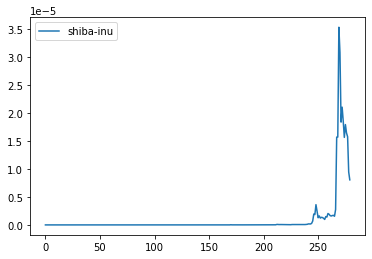

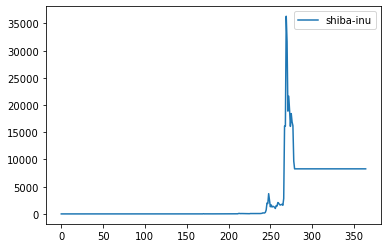

In [208]:
coin = "shiba-inu"

my_pd[[coin]].plot()
my_pd[[coin]]
my_pd[[coin]].pct_change().fillna(0).add(1).cumprod().sub(1).plot()  ##cumulative based on % change


In [140]:
print(my_pd[["shiba-inu"]].pct_change())

     shiba-inu
0          NaN
1     0.000000
2    -0.468290
3    -0.715379
4     0.111609
..         ...
115  -0.123936
116   0.044601
117   0.039953
118   0.013322
119  -0.010010

[120 rows x 1 columns]


<AxesSubplot:>

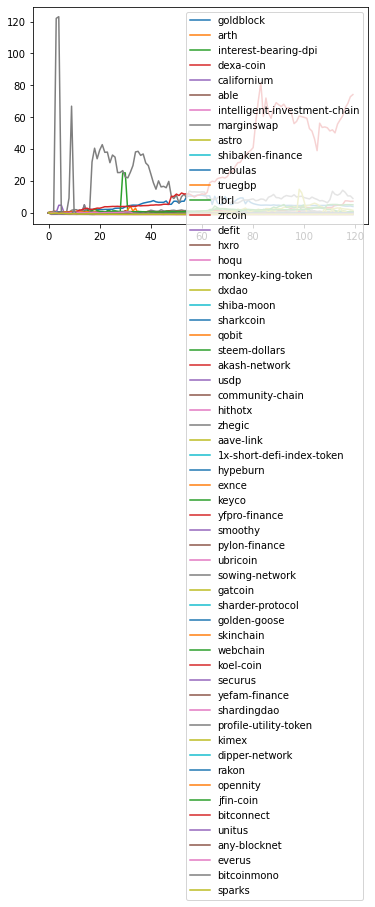

In [153]:
my_pd.iloc[:, 1: 60].pct_change().fillna(0).add(1).cumprod().sub(1).plot()  ##cumulative based on % change

In [151]:
my_pd.iloc[:, 1: 5]

,goldblock,arth,interest-bearing-dpi,dexa-coin
0,0.002913,2.588137,462.521396,0.000009
1,0.001905,2.588137,462.521396,0.000013
2,0.002204,2.075511,469.607797,0.000004
3,0.001005,1.581607,420.200529,0.000009
4,0.001594,1.450591,445.081924,0.000010
...,...,...,...,...
115,0.015809,0.240465,NaN,0.000001
116,0.015102,0.309632,NaN,0.000001
117,0.014994,0.305105,NaN,0.000002
118,0.015352,0.291184,NaN,0.000001


In [198]:
def what_if_i_invested(investment,on_day=0,limit_coins=5):
#     my_pd.iloc[:1, : 5]
    
    def buy_at(investment,sale_price):
        return investment / sale_price
    
    def sell_at(amount_of_coins,sale_price):
        return amount_of_coins * sale_price
    
    buy_df = my_pd.iloc[:1, 1 : limit_coins].apply(lambda row : buy_at(investment,row) ).reset_index()
    
    
    last_row = my_pd.iloc[-1:,1:limit_coins].reset_index()
#     print(last_row)
#     print(buy_df)
    
    print(f"Purchase price = {investment * limit_coins}")
    print(f"Profit = ")
    display(buy_df.mul(last_row).transpose().sum())
    
#     display( buy_df.mul(last_row ).transpose() )
    
                        

In [158]:
my_pd.iloc[:1, 1 : 5].apply(lambda row : row*100000)

,goldblock,arth,interest-bearing-dpi,dexa-coin
0,291.316197,258813.665237,4.625214e+07,0.921973


In [210]:
what_if_i_invested(100, limit_coins=100)  #max 7270

Purchase price = 10000
Profit = 


0    22292.589393
dtype: float64

In [204]:
build_table_Xdays_from_launch(365)

     day_number
0             0
1             1
2             2
3             3
4             4
5             5
6             6
7             7
8             8
9             9
10           10
11           11
12           12
13           13
14           14
15           15
16           16
17           17
18           18
19           19
20           20
21           21
22           22
23           23
24           24
25           25
26           26
27           27
28           28
29           29
30           30
31           31
32           32
33           33
34           34
35           35
36           36
37           37
38           38
39           39
40           40
41           41
42           42
43           43
44           44
45           45
46           46
47           47
48           48
49           49
50           50
51           51
52           52
53           53
54           54
55           55
56           56
57           57
58           58
59           59
60           60
61      

starting on passport-finance
different sized days: 173
added passport-finance to dataframe
starting on mykonos-coin
different sized days: 344
added mykonos-coin to dataframe
starting on bittwatt
added bittwatt to dataframe
starting on share-2
different sized days: 305
added share-2 to dataframe
starting on nuclum
different sized days: 314
added nuclum to dataframe
starting on standard-protocol
different sized days: 341
added standard-protocol to dataframe
starting on qmcoin
added qmcoin to dataframe
starting on gazetv
different sized days: 322
added gazetv to dataframe
starting on smart-application-chain
added smart-application-chain to dataframe
starting on idextools
different sized days: 19
added idextools to dataframe
starting on zyro
different sized days: 113
added zyro to dataframe
starting on true-usd
added true-usd to dataframe
starting on netkoin
added netkoin to dataframe
starting on chainsquare
different sized days: 332
added chainsquare to dataframe
starting on etherzero
add

starting on synlev
different sized days: 149
added synlev to dataframe
starting on habitat
different sized days: 301
added habitat to dataframe
starting on gokumarket-credit
different sized days: 168
added gokumarket-credit to dataframe
starting on schain-wallet
different sized days: 85
added schain-wallet to dataframe
starting on thorecash
added thorecash to dataframe
starting on zioncoin
added zioncoin to dataframe
starting on cryptonewsnet
different sized days: 171
added cryptonewsnet to dataframe
starting on jboxcoin
added jboxcoin to dataframe
starting on 3x-long-bitmax-token-token
added 3x-long-bitmax-token-token to dataframe
starting on 8x8-protocol
added 8x8-protocol to dataframe
starting on read-this-contract
different sized days: 212
added read-this-contract to dataframe
starting on vidyx
different sized days: 228
added vidyx to dataframe
starting on silver-coin
different sized days: 103
added silver-coin to dataframe
starting on tedesis
different sized days: 299
added tedesi

starting on superskynet
added superskynet to dataframe
starting on wrapped-zcash
different sized days: 211
added wrapped-zcash to dataframe
starting on realtoken-9336-patton-st-detroit-mi
different sized days: 256
added realtoken-9336-patton-st-detroit-mi to dataframe
starting on unigraph
different sized days: 192
added unigraph to dataframe
starting on wrapped-statera
different sized days: 229
added wrapped-statera to dataframe
starting on unicly-doki-doki-collection
different sized days: 332
added unicly-doki-doki-collection to dataframe
starting on cardano
added cardano to dataframe
starting on curve-dao-token
different sized days: 84
added curve-dao-token to dataframe
starting on yolo-cash
added yolo-cash to dataframe
starting on eth-moonshot-x-yield-set
different sized days: 175
added eth-moonshot-x-yield-set to dataframe
starting on polaris
different sized days: 314
added polaris to dataframe
starting on wazirx
added wazirx to dataframe
starting on apeusd-snx-synthetic-usd-dec-20

starting on iridium
added iridium to dataframe
starting on bitfresh
different sized days: 339
added bitfresh to dataframe
starting on bridge-finance
different sized days: 222
added bridge-finance to dataframe
starting on lockchain
added lockchain to dataframe
starting on geodb
added geodb to dataframe
starting on maxonrow
added maxonrow to dataframe
starting on largo-coin
added largo-coin to dataframe
starting on aave-tusd-v1
different sized days: 34
added aave-tusd-v1 to dataframe
starting on complus-network
different sized days: 364
added complus-network to dataframe
starting on xazab
different sized days: 327
added xazab to dataframe
starting on ixtz
different sized days: 31
added ixtz to dataframe
starting on zucoinchain
added zucoinchain to dataframe
starting on yfilend-finance
different sized days: 125
added yfilend-finance to dataframe
starting on og-fan-token
different sized days: 31
added og-fan-token to dataframe
starting on hope-token
different sized days: 342
added hope-tok

starting on communication-development-resources-token
added communication-development-resources-token to dataframe
starting on hedget
different sized days: 113
added hedget to dataframe
starting on connect-mining-coin
different sized days: 281
added connect-mining-coin to dataframe
starting on star-shib
different sized days: 353
added star-shib to dataframe
starting on strite
different sized days: 340
added strite to dataframe
starting on risecointoken
added risecointoken to dataframe
starting on peri-finance
different sized days: 353
added peri-finance to dataframe
starting on crossfi
different sized days: 346
added crossfi to dataframe
starting on cybertime-finance
different sized days: 311
added cybertime-finance to dataframe
starting on pube-finance
different sized days: 355
added pube-finance to dataframe
starting on tokenbox
added tokenbox to dataframe
starting on blockchain-certified-data-token
added blockchain-certified-data-token to dataframe
starting on toshify-finance
differ

starting on libonomy
different sized days: 278
added libonomy to dataframe
starting on ludos
added ludos to dataframe
starting on polkadomain
different sized days: 329
added polkadomain to dataframe
starting on revelation-coin
added revelation-coin to dataframe
starting on polkabridge
different sized days: 246
added polkabridge to dataframe
starting on netcoin
added netcoin to dataframe
starting on boscoin-2
added boscoin-2 to dataframe
starting on catnip-money
different sized days: 356
added catnip-money to dataframe
starting on duckdaodime
different sized days: 86
added duckdaodime to dataframe
starting on defi-omega
different sized days: 94
added defi-omega to dataframe
starting on blockclout
different sized days: 128
added blockclout to dataframe
starting on efficient-transaction-token
added efficient-transaction-token to dataframe
starting on mu-dank
different sized days: 299
added mu-dank to dataframe
starting on deepcloud-ai
added deepcloud-ai to dataframe
starting on medikey
ad

starting on buddy
added buddy to dataframe
starting on 3x-long-sushi-token
different sized days: 117
added 3x-long-sushi-token to dataframe
starting on divert-finance
different sized days: 171
added divert-finance to dataframe
starting on zusd
different sized days: 286
added zusd to dataframe
starting on ducato-protocol-token
different sized days: 122
added ducato-protocol-token to dataframe
starting on betnomi-2
different sized days: 275
added betnomi-2 to dataframe
starting on growing-fi
different sized days: 349
added growing-fi to dataframe
starting on 7up
different sized days: 158
added 7up to dataframe
starting on oxbull-tech
different sized days: 280
added oxbull-tech to dataframe
starting on hotnow
added hotnow to dataframe
starting on themis
added themis to dataframe
starting on 1x-short-eos-token
added 1x-short-eos-token to dataframe
starting on taekwondo-access-credit
different sized days: 354
added taekwondo-access-credit to dataframe
starting on coinsbit-token
added coinsb

starting on anon
added anon to dataframe
starting on penguin
added penguin to dataframe
starting on game-stars
added game-stars to dataframe
starting on etheal
added etheal to dataframe
starting on omcoin
different sized days: 338
added omcoin to dataframe
starting on novo
different sized days: 139
added novo to dataframe
starting on locgame
different sized days: 346
added locgame to dataframe
starting on pumapay
added pumapay to dataframe
starting on thingsoperatingsystem
added thingsoperatingsystem to dataframe
starting on meliora
different sized days: 311
added meliora to dataframe
starting on versacoin
different sized days: 299
added versacoin to dataframe
starting on suni
different sized days: 331
added suni to dataframe
starting on refork
different sized days: 97
added refork to dataframe
starting on temco
added temco to dataframe
starting on npo-coin
different sized days: 204
added npo-coin to dataframe
starting on viagra-token
different sized days: 359
added viagra-token to dat

starting on young-boys-fan-token
different sized days: 249
added young-boys-fan-token to dataframe
starting on litecoin-finance
added litecoin-finance to dataframe
starting on dudgx
added dudgx to dataframe
starting on rozeus
added rozeus to dataframe
starting on 3x-short-balancer-token
different sized days: 76
added 3x-short-balancer-token to dataframe
starting on mirrored-google
different sized days: 236
added mirrored-google to dataframe
starting on axioms
different sized days: 133
added axioms to dataframe
starting on casper-network
different sized days: 355
added casper-network to dataframe
starting on bitriver
different sized days: 340
added bitriver to dataframe
starting on undo-token
different sized days: 358
added undo-token to dataframe
starting on mobilego
added mobilego to dataframe
starting on tadpole-finance
different sized days: 178
added tadpole-finance to dataframe
starting on videocoin
added videocoin to dataframe
starting on somesing
added somesing to dataframe
start

added caica-coin to dataframe
starting on kansas-city-chiefs-win-super-bowl
different sized days: 358
added kansas-city-chiefs-win-super-bowl to dataframe
starting on zenfuse
different sized days: 144
added zenfuse to dataframe
starting on xbn
different sized days: 321
added xbn to dataframe
starting on hokkaidu-inu
different sized days: 337
added hokkaidu-inu to dataframe
starting on delphi-chain-link
different sized days: 229
added delphi-chain-link to dataframe
starting on cafeswap-token
different sized days: 269
added cafeswap-token to dataframe
starting on luxurious-pro-network-token
different sized days: 284
added luxurious-pro-network-token to dataframe
starting on safedog-protocol
different sized days: 354
added safedog-protocol to dataframe
starting on bluechips-token
added bluechips-token to dataframe
starting on kiwi-token
added kiwi-token to dataframe
starting on setc
different sized days: 305
added setc to dataframe
starting on safepal
different sized days: 262
added safep

starting on curio
added curio to dataframe
starting on visor
different sized days: 296
added visor to dataframe
starting on nyan-v2
different sized days: 173
added nyan-v2 to dataframe
starting on blackpearl-chain
added blackpearl-chain to dataframe
starting on daex
added daex to dataframe
starting on tena
added tena to dataframe
starting on htmlcoin
added htmlcoin to dataframe
starting on currency-network
added currency-network to dataframe
starting on waffle
different sized days: 329
added waffle to dataframe
starting on 3x-long-okb-token
added 3x-long-okb-token to dataframe
starting on international-cryptox
added international-cryptox to dataframe
starting on havven
added havven to dataframe
starting on zuplo
different sized days: 179
added zuplo to dataframe
starting on marsmission
different sized days: 333
added marsmission to dataframe
starting on qash
added qash to dataframe
starting on seedswap-token
different sized days: 361
added seedswap-token to dataframe
starting on decent

starting on exmr-monero
added exmr-monero to dataframe
starting on zzz-finance-v2
different sized days: 237
added zzz-finance-v2 to dataframe
starting on atbcoin
added atbcoin to dataframe
starting on perkscoin
added perkscoin to dataframe
starting on cezo
different sized days: 269
added cezo to dataframe
starting on crowns
different sized days: 255
added crowns to dataframe
starting on saveplanetearth
different sized days: 340
added saveplanetearth to dataframe
starting on jindo-inu
different sized days: 358
added jindo-inu to dataframe
starting on generation-of-yield
different sized days: 197
added generation-of-yield to dataframe
starting on 3x-short-ethereum-classic-token
added 3x-short-ethereum-classic-token to dataframe
starting on bigbom-eco
added bigbom-eco to dataframe
starting on livenpay
added livenpay to dataframe
starting on polaris-share
different sized days: 255
added polaris-share to dataframe
starting on zum-token
added zum-token to dataframe
starting on tron-atm
diffe

starting on rivetz
added rivetz to dataframe
starting on synth-soil
different sized days: 309
added synth-soil to dataframe
starting on 3x-short-stellar-token
different sized days: 202
added 3x-short-stellar-token to dataframe
starting on t-os
added t-os to dataframe
starting on palletone
added palletone to dataframe
starting on rise-protocol
different sized days: 277
added rise-protocol to dataframe
starting on prophecy
different sized days: 237
added prophecy to dataframe
starting on yd-btc-mar21
different sized days: 272
added yd-btc-mar21 to dataframe
starting on sphere
added sphere to dataframe
starting on sentinel-protocol
added sentinel-protocol to dataframe
starting on partner
added partner to dataframe
starting on financex-exchange-token
added financex-exchange-token to dataframe
starting on parachute
added parachute to dataframe
starting on rupiah-token
added rupiah-token to dataframe
starting on lipchain
added lipchain to dataframe
starting on afin-coin
added afin-coin to da

starting on oro
different sized days: 176
added oro to dataframe
starting on zmine
added zmine to dataframe
starting on datamine
different sized days: 32
added datamine to dataframe
starting on xpet-coin
added xpet-coin to dataframe
starting on tagcoin
added tagcoin to dataframe
starting on rakun
added rakun to dataframe
starting on genexi
added genexi to dataframe
starting on fortknoxter
added fortknoxter to dataframe
starting on app-alliance-association
added app-alliance-association to dataframe
starting on blockmason-credit-protocol
added blockmason-credit-protocol to dataframe
starting on moonstar
different sized days: 344
added moonstar to dataframe
starting on chainium
added chainium to dataframe
starting on aave-enj-v1
different sized days: 118
added aave-enj-v1 to dataframe
starting on minerva-wallet
different sized days: 322
added minerva-wallet to dataframe
starting on tronipay
added tronipay to dataframe
starting on sono
added sono to dataframe
starting on mti-finance
diffe

starting on huobi-btc
different sized days: 159
added huobi-btc to dataframe
starting on unicly-waifu-collection
different sized days: 348
added unicly-waifu-collection to dataframe
starting on koinos
different sized days: 177
added koinos to dataframe
starting on eth-btc-75-25-weight-set
different sized days: 124
added eth-btc-75-25-weight-set to dataframe
starting on btf
added btf to dataframe
starting on wallet-plus-x
added wallet-plus-x to dataframe
starting on wax
added wax to dataframe
starting on ontology
added ontology to dataframe
starting on gsenetwork
added gsenetwork to dataframe
starting on mex
added mex to dataframe
starting on emrals
added emrals to dataframe
starting on yoink
different sized days: 147
added yoink to dataframe
starting on konjungate
added konjungate to dataframe
starting on baby-shiba
different sized days: 355
added baby-shiba to dataframe
starting on universal-dollar
different sized days: 273
added universal-dollar to dataframe
starting on keytango
diff

starting on xeonbit-token
added xeonbit-token to dataframe
starting on five-balance
added five-balance to dataframe
starting on liquid-lottery-rtc
different sized days: 293
added liquid-lottery-rtc to dataframe
starting on satoshivision-coin
different sized days: 191
added satoshivision-coin to dataframe
starting on paycon-token
different sized days: 95
added paycon-token to dataframe
starting on aga-rewards-2
different sized days: 287
added aga-rewards-2 to dataframe
starting on chartex
different sized days: 119
added chartex to dataframe
starting on quai-dao
different sized days: 254
added quai-dao to dataframe
starting on robo-token
different sized days: 313
added robo-token to dataframe
starting on dequant
added dequant to dataframe
starting on stabinol
different sized days: 297
added stabinol to dataframe
starting on tama-egg-niftygotchi
different sized days: 193
added tama-egg-niftygotchi to dataframe
starting on timers
different sized days: 146
added timers to dataframe
starting

added r34p to dataframe
starting on okb
added okb to dataframe
starting on nss-coin
added nss-coin to dataframe
starting on blinky-bob
different sized days: 361
added blinky-bob to dataframe
starting on eth-rsi-60-40-yield-set
added eth-rsi-60-40-yield-set to dataframe
starting on converter-finance
different sized days: 312
added converter-finance to dataframe
starting on pippi-finance
different sized days: 344
added pippi-finance to dataframe
starting on chiliz
added chiliz to dataframe
starting on brickchain-finance
different sized days: 326
added brickchain-finance to dataframe
starting on bitcoinx
added bitcoinx to dataframe
starting on sphere-social
added sphere-social to dataframe
starting on aurusgold
different sized days: 30
added aurusgold to dataframe
starting on mineum
added mineum to dataframe
starting on wooshcoin-io
added wooshcoin-io to dataframe
starting on copiosa
different sized days: 335
added copiosa to dataframe
starting on kuma-inu
different sized days: 359
added 

starting on zero-utility-token
different sized days: 135
added zero-utility-token to dataframe
starting on parkingo
added parkingo to dataframe
starting on banklife
added banklife to dataframe
starting on harta-tech
different sized days: 344
added harta-tech to dataframe
starting on wiix-coin
added wiix-coin to dataframe
starting on litentry
different sized days: 258
added litentry to dataframe
starting on datbit
added datbit to dataframe
starting on sperax
different sized days: 95
added sperax to dataframe
starting on cryptotipsfr
different sized days: 95
added cryptotipsfr to dataframe
starting on piedao-dough-v2
different sized days: 134
added piedao-dough-v2 to dataframe
starting on all-me
added all-me to dataframe
starting on aloha
different sized days: 277
added aloha to dataframe
starting on cheese
added cheese to dataframe
starting on master-usd
different sized days: 16
added master-usd to dataframe
starting on tripio
added tripio to dataframe
starting on bearn-fi
different siz

added elysia to dataframe
starting on eazy
added eazy to dataframe
starting on wrapped-bitcoin-diamond
different sized days: 364
added wrapped-bitcoin-diamond to dataframe
starting on opalcoin
different sized days: 150
added opalcoin to dataframe
starting on punk-female
different sized days: 280
added punk-female to dataframe
starting on degov
different sized days: 193
added degov to dataframe
starting on bitsum
added bitsum to dataframe
starting on kattana
different sized days: 322
added kattana to dataframe
starting on unicrypt
different sized days: 44
added unicrypt to dataframe
starting on myubi
added myubi to dataframe
starting on nantrade
added nantrade to dataframe
starting on pixl-coin
different sized days: 346
added pixl-coin to dataframe
starting on fudfinance
different sized days: 139
added fudfinance to dataframe
starting on klondike-btc
different sized days: 251
added klondike-btc to dataframe
starting on web-token-pay
added web-token-pay to dataframe
starting on candy-box

starting on empower-network
different sized days: 84
added empower-network to dataframe
starting on tradestars
different sized days: 346
added tradestars to dataframe
starting on siaclassic
added siaclassic to dataframe
starting on snglsdao-governance-token
different sized days: 63
added snglsdao-governance-token to dataframe
starting on spectrum
added spectrum to dataframe
starting on iticoin
added iticoin to dataframe
starting on elevation-token
different sized days: 98
added elevation-token to dataframe
starting on bancor-governance-token
different sized days: 277
added bancor-governance-token to dataframe
starting on basis-gold
different sized days: 324
added basis-gold to dataframe
starting on crypto-price-index
different sized days: 90
added crypto-price-index to dataframe
starting on weedcash
added weedcash to dataframe
starting on health-token
different sized days: 358
added health-token to dataframe
starting on yaxis
different sized days: 128
added yaxis to dataframe
starting 

starting on evedo
added evedo to dataframe
starting on new-year-bull
different sized days: 156
added new-year-bull to dataframe
starting on htm
different sized days: 319
added htm to dataframe
starting on tap
added tap to dataframe
starting on commons-earth
different sized days: 279
added commons-earth to dataframe
starting on birthday-cake
different sized days: 300
added birthday-cake to dataframe
starting on snovio
added snovio to dataframe
starting on blockidcoin
added blockidcoin to dataframe
starting on atn
added atn to dataframe
starting on lotdog
different sized days: 362
added lotdog to dataframe
starting on tokyo
added tokyo to dataframe
starting on mci-coin
different sized days: 120
added mci-coin to dataframe
starting on bitcoin-ultra
added bitcoin-ultra to dataframe
starting on dapp-com
added dapp-com to dataframe
starting on content-value-network
added content-value-network to dataframe
starting on shitcoin
added shitcoin to dataframe
starting on coinlion
added coinlion to

starting on cxn-network
different sized days: 139
added cxn-network to dataframe
starting on nocapcoin
different sized days: 358
added nocapcoin to dataframe
starting on hurricane
different sized days: 360
added hurricane to dataframe
starting on taurus-chain
different sized days: 364
added taurus-chain to dataframe
starting on infinity-esaham
added infinity-esaham to dataframe
starting on dev-protocol
different sized days: 11
added dev-protocol to dataframe
starting on qoober
different sized days: 110
added qoober to dataframe
starting on mao-zedong
added mao-zedong to dataframe
starting on wrapped-cryptokitties
added wrapped-cryptokitties to dataframe
starting on armx-unidos
different sized days: 220
added armx-unidos to dataframe
starting on one-ledger
added one-ledger to dataframe
starting on data
added data to dataframe
starting on nibbleclassic
added nibbleclassic to dataframe
starting on web-innovation-ph
added web-innovation-ph to dataframe
starting on chai
added chai to datafr

starting on bilaxy-token
added bilaxy-token to dataframe
starting on soge
different sized days: 319
added soge to dataframe
starting on block-array
added block-array to dataframe
starting on alchemix-usd
different sized days: 311
added alchemix-usd to dataframe
starting on 3x-long-defi-index-token
different sized days: 76
added 3x-long-defi-index-token to dataframe
starting on kaleido
added kaleido to dataframe
starting on cipher-core-token
different sized days: 87
added cipher-core-token to dataframe
starting on up-token
added up-token to dataframe
starting on cross-finance
different sized days: 156
added cross-finance to dataframe
starting on aeternity
added aeternity to dataframe
starting on oxbitcoin
added oxbitcoin to dataframe
starting on peach
different sized days: 358
added peach to dataframe
starting on glitch-protocol
different sized days: 242
added glitch-protocol to dataframe
starting on finexbox-token
added finexbox-token to dataframe
starting on elephant-money
different s

starting on tigercash
added tigercash to dataframe
starting on magic-e-stock
different sized days: 364
added magic-e-stock to dataframe
starting on elynet-token
different sized days: 212
added elynet-token to dataframe
starting on vcash-token
added vcash-token to dataframe
starting on memex
different sized days: 355
added memex to dataframe
starting on tsuki-inu
different sized days: 363
added tsuki-inu to dataframe
starting on spacechain-erc-20
added spacechain-erc-20 to dataframe
starting on ferma
different sized days: 306
added ferma to dataframe
starting on dreamteam3
added dreamteam3 to dataframe
starting on ally
added ally to dataframe
starting on lance-coin
different sized days: 332
added lance-coin to dataframe
starting on circleswap
different sized days: 230
added circleswap to dataframe
starting on piedao-balanced-crypto-pie
different sized days: 228
added piedao-balanced-crypto-pie to dataframe
starting on eosbet
added eosbet to dataframe
starting on dexe
different sized day

starting on portal
added portal to dataframe
starting on arweave
added arweave to dataframe
starting on arc-governance
different sized days: 364
added arc-governance to dataframe
starting on yffs
different sized days: 102
added yffs to dataframe
starting on ultiledger
added ultiledger to dataframe
starting on kyc-crypto
different sized days: 208
added kyc-crypto to dataframe
starting on pos-coin
added pos-coin to dataframe
starting on gogo-finance
different sized days: 258
added gogo-finance to dataframe
starting on pegasus
added pegasus to dataframe
starting on gamestop-finance
different sized days: 255
added gamestop-finance to dataframe
starting on bitcoin-unicorn
added bitcoin-unicorn to dataframe
starting on oxo-farm
different sized days: 342
added oxo-farm to dataframe
starting on pxusd-synthetic-usd-expiring-31-mar-2022
different sized days: 340
added pxusd-synthetic-usd-expiring-31-mar-2022 to dataframe
starting on mm-token
different sized days: 199
added mm-token to dataframe


starting on dfinance
different sized days: 272
added dfinance to dataframe
starting on ethereum-stake
different sized days: 213
added ethereum-stake to dataframe
starting on alchemist
different sized days: 318
added alchemist to dataframe
starting on stellarpayglobal
different sized days: 35
added stellarpayglobal to dataframe
starting on zoom-protocol
different sized days: 143
added zoom-protocol to dataframe
starting on blitzpredict
added blitzpredict to dataframe
starting on bafi-finance-token
different sized days: 226
added bafi-finance-token to dataframe
starting on bit-z-token
added bit-z-token to dataframe
starting on royal-protocol
different sized days: 351
added royal-protocol to dataframe
starting on matic-aave-uni
different sized days: 329
added matic-aave-uni to dataframe
starting on phoswap
different sized days: 255
added phoswap to dataframe
starting on the-lab-finance
different sized days: 342
added the-lab-finance to dataframe
starting on safetesla
different sized days:

starting on venus-usdc
different sized days: 263
added venus-usdc to dataframe
starting on polkafoundry
different sized days: 299
added polkafoundry to dataframe
starting on myfichain
added myfichain to dataframe
starting on aave-ren
different sized days: 294
added aave-ren to dataframe
starting on definer
different sized days: 143
added definer to dataframe
starting on effect-network
added effect-network to dataframe
starting on dscvr-finance
different sized days: 343
added dscvr-finance to dataframe
starting on mnpostree
different sized days: 291
added mnpostree to dataframe
starting on counterparty
added counterparty to dataframe
starting on cryptassist
different sized days: 257
added cryptassist to dataframe
starting on digex
different sized days: 155
added digex to dataframe
starting on altmarkets-coin
added altmarkets-coin to dataframe
starting on polyvolve-finance
different sized days: 348
added polyvolve-finance to dataframe
starting on thinkium
different sized days: 364
added 

starting on snapparazzi
added snapparazzi to dataframe
starting on bitcoin-interest
added bitcoin-interest to dataframe
starting on route
different sized days: 241
added route to dataframe
starting on renbch
different sized days: 119
added renbch to dataframe
starting on enceladus-network
different sized days: 203
added enceladus-network to dataframe
starting on coti
added coti to dataframe
starting on safelcarus
different sized days: 350
added safelcarus to dataframe
starting on collective
different sized days: 310
added collective to dataframe
starting on spheroid-universe
different sized days: 73
added spheroid-universe to dataframe
starting on panda-finance
different sized days: 360
added panda-finance to dataframe
starting on power-index-pool-token
different sized days: 194
added power-index-pool-token to dataframe
starting on defi-firefly
different sized days: 185
added defi-firefly to dataframe
starting on koda-finance
different sized days: 360
added koda-finance to dataframe
st

starting on cashbet-coin
added cashbet-coin to dataframe
starting on guncoin
added guncoin to dataframe
starting on fatcoin
added fatcoin to dataframe
starting on lyfe
added lyfe to dataframe
starting on hackspace-capital
added hackspace-capital to dataframe
starting on dfuture
different sized days: 290
added dfuture to dataframe
starting on piedao-defi-large-cap
different sized days: 139
added piedao-defi-large-cap to dataframe
starting on qanplatform
different sized days: 121
added qanplatform to dataframe
starting on erotica-2
different sized days: 358
added erotica-2 to dataframe
starting on eos-eth
added eos-eth to dataframe
starting on 0-5x-long-cosmos-token
different sized days: 282
added 0-5x-long-cosmos-token to dataframe
starting on safemars
different sized days: 301
added safemars to dataframe
starting on jobchain
added jobchain to dataframe
starting on funder-one
different sized days: 303
added funder-one to dataframe
starting on trust-ether-reorigin
added trust-ether-reori

starting on cryptocurrency
added cryptocurrency to dataframe
starting on game-fanz
added game-fanz to dataframe
starting on plair
added plair to dataframe
starting on iqoniq
different sized days: 319
added iqoniq to dataframe
starting on armtoken
different sized days: 124
added armtoken to dataframe
starting on mxc
added mxc to dataframe
starting on ong
added ong to dataframe
starting on yd-eth-jun21
different sized days: 315
added yd-eth-jun21 to dataframe
starting on loom-network-new
different sized days: 322
added loom-network-new to dataframe
starting on pokeball
different sized days: 237
added pokeball to dataframe
starting on okschain
added okschain to dataframe
starting on defi-top-5-tokens-index
different sized days: 241
added defi-top-5-tokens-index to dataframe
starting on froge-finance
different sized days: 327
added froge-finance to dataframe
starting on moon-owl
different sized days: 361
added moon-owl to dataframe
starting on fairyland
added fairyland to dataframe
startin

added transfast to dataframe
starting on cryptoworld-vip
added cryptoworld-vip to dataframe
starting on blox
added blox to dataframe
starting on chimaera
added chimaera to dataframe
starting on energoncoin
added energoncoin to dataframe
starting on fio-protocol
different sized days: 52
added fio-protocol to dataframe
starting on intellishare
added intellishare to dataframe
starting on va-na-su
different sized days: 116
added va-na-su to dataframe
starting on algovest
different sized days: 258
added algovest to dataframe
starting on apollon-limassol
different sized days: 169
added apollon-limassol to dataframe
starting on kebab-token
different sized days: 243
added kebab-token to dataframe
starting on kylin-network
different sized days: 285
added kylin-network to dataframe
starting on shiba-swim
different sized days: 359
added shiba-swim to dataframe
starting on swap
added swap to dataframe
starting on bitscoin
different sized days: 175
added bitscoin to dataframe
starting on auto
diffe

starting on 2gether-2
different sized days: 307
added 2gether-2 to dataframe
starting on triipmiles
different sized days: 150
added triipmiles to dataframe
starting on yfet
different sized days: 133
added yfet to dataframe
starting on nuggets
added nuggets to dataframe
starting on cryptocurrency-top-10-tokens-index
different sized days: 241
added cryptocurrency-top-10-tokens-index to dataframe
starting on peet-defi
different sized days: 228
added peet-defi to dataframe
starting on utu-coin
different sized days: 146
added utu-coin to dataframe
starting on globex
added globex to dataframe
starting on mercurial
different sized days: 364
added mercurial to dataframe
starting on tepleton
added tepleton to dataframe
starting on voyager
added voyager to dataframe
starting on platincoin
added platincoin to dataframe
starting on usd-bancor
added usd-bancor to dataframe
starting on cherry-token
added cherry-token to dataframe
starting on 3x-short-sushi-token
different sized days: 117
added 3x-sh

added lightening-cash to dataframe
starting on shiba-cosmos
different sized days: 357
added shiba-cosmos to dataframe
starting on super-trip-chain
added super-trip-chain to dataframe
starting on thunderbolt
different sized days: 342
added thunderbolt to dataframe
starting on storiqa
added storiqa to dataframe
starting on bingo-cash
different sized days: 364
added bingo-cash to dataframe
starting on cryptogalaxy
added cryptogalaxy to dataframe
starting on mobifi
different sized days: 320
added mobifi to dataframe
starting on valuecybertoken
added valuecybertoken to dataframe
starting on beetr
different sized days: 213
added beetr to dataframe
starting on everipedia
added everipedia to dataframe
starting on fear-greed-sentiment-set-ii
different sized days: 60
added fear-greed-sentiment-set-ii to dataframe
starting on wadzpay-token
different sized days: 197
added wadzpay-token to dataframe
starting on 3x-long-litecoin-token
added 3x-long-litecoin-token to dataframe
starting on gas-cash-ba

starting on glosfer-token
added glosfer-token to dataframe
starting on yearn-finance-passive-income
different sized days: 133
added yearn-finance-passive-income to dataframe
starting on storm
added storm to dataframe
starting on publish
added publish to dataframe
starting on spectrecoin
added spectrecoin to dataframe
starting on unicly-aavegotchi-astronauts-collection
different sized days: 333
added unicly-aavegotchi-astronauts-collection to dataframe
starting on ethereum-push-notification-service
different sized days: 326
added ethereum-push-notification-service to dataframe
starting on compound-0x
added compound-0x to dataframe
starting on cnyq-stablecoin-by-q-dao-v1
different sized days: 303
added cnyq-stablecoin-by-q-dao-v1 to dataframe
starting on mobox
different sized days: 326
added mobox to dataframe
starting on matic-aave-usdc
different sized days: 278
added matic-aave-usdc to dataframe
starting on bitpower
different sized days: 220
added bitpower to dataframe
starting on cato

starting on puriever
different sized days: 126
added puriever to dataframe
starting on crypto-candy
different sized days: 245
added crypto-candy to dataframe
starting on consensus-cell-network
different sized days: 129
added consensus-cell-network to dataframe
starting on swaap-stablecoin
different sized days: 271
added swaap-stablecoin to dataframe
starting on coinloan
added coinloan to dataframe
starting on italo
added italo to dataframe
starting on freeway-token
different sized days: 165
added freeway-token to dataframe
starting on dash-cash
added dash-cash to dataframe
starting on ans-crypto-coin
different sized days: 329
added ans-crypto-coin to dataframe
starting on bread
added bread to dataframe
starting on vfox
different sized days: 353
added vfox to dataframe
starting on farmer-defi
different sized days: 364
added farmer-defi to dataframe
starting on voltbit
different sized days: 361
added voltbit to dataframe
starting on drep-new
different sized days: 312
added drep-new to da

starting on super-zero
added super-zero to dataframe
starting on xtcom-token
added xtcom-token to dataframe
starting on you-chain
added you-chain to dataframe
starting on openalexa-protocol
different sized days: 109
added openalexa-protocol to dataframe
starting on tradeplus
added tradeplus to dataframe
starting on coinpoker
added coinpoker to dataframe
starting on chainswap
different sized days: 335
added chainswap to dataframe
starting on simian-finance
different sized days: 318
added simian-finance to dataframe
starting on aleph
different sized days: 29
added aleph to dataframe
starting on chi-gastoken
different sized days: 14
added chi-gastoken to dataframe
starting on xwc-dice-token
added xwc-dice-token to dataframe
starting on buckhath-coin
added buckhath-coin to dataframe
starting on riecoin
added riecoin to dataframe
starting on themis-2
different sized days: 218
added themis-2 to dataframe
starting on limeswap
different sized days: 348
added limeswap to dataframe
starting on h

added titanswap to dataframe
starting on venus-ltc
different sized days: 264
added venus-ltc to dataframe
starting on nia-token
different sized days: 362
added nia-token to dataframe
starting on micromines
added micromines to dataframe
starting on rubic
different sized days: 128
added rubic to dataframe
starting on cashbackpro
different sized days: 155
added cashbackpro to dataframe
starting on fiola
different sized days: 230
added fiola to dataframe
starting on warlord-token
different sized days: 262
added warlord-token to dataframe
starting on stellar-gold
added stellar-gold to dataframe
starting on yap-stone
added yap-stone to dataframe
starting on cr-coin
different sized days: 312
added cr-coin to dataframe
starting on empow
different sized days: 83
added empow to dataframe
starting on oceanex-token
added oceanex-token to dataframe
starting on foresight
different sized days: 110
added foresight to dataframe
starting on eth-50-day-ma-crossover-set
different sized days: 16
added eth-

added bitblocks-finance to dataframe
starting on medican-coin
different sized days: 235
added medican-coin to dataframe
starting on deus-synthetic-coinbase-iou
different sized days: 243
added deus-synthetic-coinbase-iou to dataframe
starting on yield-bear
different sized days: 304
added yield-bear to dataframe
starting on tokenlon
different sized days: 214
added tokenlon to dataframe
starting on sugarchain
added sugarchain to dataframe
starting on hirevibes
added hirevibes to dataframe
starting on siaprime-coin
added siaprime-coin to dataframe
starting on shadow-token
added shadow-token to dataframe
starting on bficoin
different sized days: 333
added bficoin to dataframe
starting on spacecowboy
different sized days: 285
added spacecowboy to dataframe
starting on blocklancer
added blocklancer to dataframe
starting on yflink
different sized days: 78
added yflink to dataframe
starting on eurxb
different sized days: 294
added eurxb to dataframe
starting on deflect
different sized days: 206

starting on goldkash
added goldkash to dataframe
starting on timelockcoin
different sized days: 66
added timelockcoin to dataframe
starting on littlesesame
added littlesesame to dataframe
starting on lnko-token
added lnko-token to dataframe
starting on ara-token
different sized days: 311
added ara-token to dataframe
starting on ubiquitous-social-network-service
added ubiquitous-social-network-service to dataframe
starting on origintrail
added origintrail to dataframe
starting on graft-blockchain
added graft-blockchain to dataframe
starting on busy-dao
different sized days: 336
added busy-dao to dataframe
starting on noah-coin
added noah-coin to dataframe
starting on media-network
different sized days: 343
added media-network to dataframe
starting on lync-network
different sized days: 182
added lync-network to dataframe
starting on nolecoin
added nolecoin to dataframe
starting on ampleforth-governance-token
different sized days: 334
added ampleforth-governance-token to dataframe
startin

starting on bonfire
different sized days: 340
added bonfire to dataframe
starting on cbdao
different sized days: 83
added cbdao to dataframe
starting on omc-group
different sized days: 179
added omc-group to dataframe
starting on tronfamily
different sized days: 86
added tronfamily to dataframe
starting on abcc-token
added abcc-token to dataframe
starting on eboost
added eboost to dataframe
starting on galactrum
added galactrum to dataframe
starting on atlantic-finance
different sized days: 349
added atlantic-finance to dataframe
starting on kusama
added kusama to dataframe
starting on magi
added magi to dataframe
starting on safecookie
different sized days: 353
added safecookie to dataframe
starting on 1million-nfts
different sized days: 338
added 1million-nfts to dataframe
starting on quant-network
added quant-network to dataframe
starting on vectorium
different sized days: 128
added vectorium to dataframe
starting on aen-smart-token
different sized days: 346
added aen-smart-token to

starting on telcoin
added telcoin to dataframe
starting on zantepay
added zantepay to dataframe
starting on sora-validator-token
different sized days: 198
added sora-validator-token to dataframe
starting on daxhund
different sized days: 332
added daxhund to dataframe
starting on vodi-x
added vodi-x to dataframe
starting on cryptoping
added cryptoping to dataframe
starting on trustpad
different sized days: 348
added trustpad to dataframe
starting on veraswap
different sized days: 292
added veraswap to dataframe
starting on ravencoin
added ravencoin to dataframe
starting on suku
different sized days: 74
added suku to dataframe
starting on albos
different sized days: 44
added albos to dataframe
starting on bitcoin-rhodium
added bitcoin-rhodium to dataframe
starting on argon
different sized days: 291
added argon to dataframe
starting on safegem
different sized days: 358
added safegem to dataframe
starting on eva-coin
added eva-coin to dataframe
starting on aave-susd
different sized days: 2

starting on hurify
added hurify to dataframe
starting on corra-finance
different sized days: 364
added corra-finance to dataframe
starting on turex
different sized days: 361
added turex to dataframe
starting on clearpoll
added clearpoll to dataframe
starting on swamp-coin
added swamp-coin to dataframe
starting on cpchain
added cpchain to dataframe
starting on jewel
added jewel to dataframe
starting on mooni
different sized days: 340
added mooni to dataframe
starting on hland-token
different sized days: 208
added hland-token to dataframe
starting on viking-swap
different sized days: 296
added viking-swap to dataframe
starting on alien-worlds
different sized days: 320
added alien-worlds to dataframe
starting on dionpay
different sized days: 77
added dionpay to dataframe
starting on erc20
added erc20 to dataframe
starting on proof-of-liquidity
different sized days: 34
added proof-of-liquidity to dataframe
starting on atlas
added atlas to dataframe
starting on global-reserve-system
added g

added vbswap to dataframe
starting on giant
added giant to dataframe
starting on fanstime
added fanstime to dataframe
starting on revolt
different sized days: 359
added revolt to dataframe
starting on livepeer
added livepeer to dataframe
starting on condominium
added condominium to dataframe
starting on eox
different sized days: 274
added eox to dataframe
starting on fuzzballs
added fuzzballs to dataframe
starting on truedeck
added truedeck to dataframe
starting on sjwcoin
added sjwcoin to dataframe
starting on cash2
added cash2 to dataframe
starting on knekted
added knekted to dataframe
starting on quotation-coin
added quotation-coin to dataframe
starting on slothcoin
added slothcoin to dataframe
starting on cate-shiba
different sized days: 364
added cate-shiba to dataframe
starting on titcoin
added titcoin to dataframe
starting on nftpunk-finance
different sized days: 359
added nftpunk-finance to dataframe
starting on smartkey
different sized days: 212
added smartkey to dataframe
sta

added pegascoin to dataframe
starting on yooshi
different sized days: 360
added yooshi to dataframe
starting on glox-finance
different sized days: 200
added glox-finance to dataframe
starting on kira-network
different sized days: 190
added kira-network to dataframe
starting on unique-one
different sized days: 215
added unique-one to dataframe
starting on neo-holistic-coin
different sized days: 313
added neo-holistic-coin to dataframe
starting on bitcoin-subsidium
added bitcoin-subsidium to dataframe
starting on zippie
added zippie to dataframe
starting on olympus
different sized days: 306
added olympus to dataframe
starting on yunex
added yunex to dataframe
starting on pop
different sized days: 313
added pop to dataframe
starting on sapien
added sapien to dataframe
starting on biopset
different sized days: 353
added biopset to dataframe
starting on time-new-bank
added time-new-bank to dataframe
starting on bilira
added bilira to dataframe
starting on nyzo
added nyzo to dataframe
starti

added buy-coin-pos to dataframe
starting on fuze-token
added fuze-token to dataframe
starting on cartesi
added cartesi to dataframe
starting on bitup-token
added bitup-token to dataframe
starting on waterdrop
different sized days: 183
added waterdrop to dataframe
starting on bcat
added bcat to dataframe
starting on etheroll
added etheroll to dataframe
starting on sora
added sora to dataframe
starting on luxcoin
added luxcoin to dataframe
starting on blockchain-cuties-universe-governance
different sized days: 299
added blockchain-cuties-universe-governance to dataframe
starting on heidi
different sized days: 33
added heidi to dataframe
starting on 0-5x-long-shitcoin-index-token
different sized days: 276
added 0-5x-long-shitcoin-index-token to dataframe
starting on bitgem
added bitgem to dataframe
starting on v-id-blockchain
added v-id-blockchain to dataframe
starting on aggregator-network
different sized days: 358
added aggregator-network to dataframe
starting on blockv
added blockv to 

added aave-usdt-v1 to dataframe
starting on codex
added codex to dataframe
starting on bgt
added bgt to dataframe
starting on oviex
different sized days: 348
added oviex to dataframe
starting on moontrust
different sized days: 354
added moontrust to dataframe
starting on thrivechain
added thrivechain to dataframe
starting on torchain
added torchain to dataframe
starting on moon-day-plus
different sized days: 307
added moon-day-plus to dataframe
starting on iexec-rlc
added iexec-rlc to dataframe
starting on ecoreal-estate
added ecoreal-estate to dataframe
starting on mossland
added mossland to dataframe
starting on helio
different sized days: 349
added helio to dataframe
starting on hope
different sized days: 146
added hope to dataframe
starting on meteorite-network
different sized days: 333
added meteorite-network to dataframe
starting on pinknode
different sized days: 357
added pinknode to dataframe
starting on crypto-holding-frank-token
added crypto-holding-frank-token to dataframe
s

added morpher to dataframe
starting on mirrored-goldman-sachs
different sized days: 286
added mirrored-goldman-sachs to dataframe
starting on icolcoin
different sized days: 54
added icolcoin to dataframe
starting on goes-up-higher
different sized days: 364
added goes-up-higher to dataframe
starting on maxgoat
different sized days: 358
added maxgoat to dataframe
starting on apple-network
added apple-network to dataframe
starting on photon
added photon to dataframe
starting on cryptobuyer-token
added cryptobuyer-token to dataframe
starting on aragon
added aragon to dataframe
starting on street-credit
different sized days: 364
added street-credit to dataframe
starting on nft-protocol
different sized days: 89
added nft-protocol to dataframe
starting on excavo-finance
different sized days: 242
added excavo-finance to dataframe
starting on sbank
different sized days: 52
added sbank to dataframe
starting on blastx
added blastx to dataframe
starting on deimos-token
different sized days: 329
ad

In [212]:
# I Should normalise to :

"""
Day | Coin | Price | Price_change

"""

'\nDay | Coin | Price | Price_change\n\n'

In [222]:
list1 = [1221,1211,1,2]
list2 = ["a","b","c","d"]

list3 = list1 + list2

df_test = pd.DataFrame(columns=["list1_name","list2_name"])
d_test = pd.DataFrame()
d_test["list1"] = list1
d_test["list2"] = list2
d_test["list1"] = list1
d_test["list2"] = list2

In [223]:
print(d_test)

   list1 list2
0   1221     a
1   1211     b
2      1     c
3      2     d


In [227]:
day_numbers = list(range(0, 100))
coin_df = pd.DataFrame(day_numbers, columns=["day_number"])
coin_df["coin_id"] = coin
print(coin_df)

    day_number    coin_id
0            0  shiba-inu
1            1  shiba-inu
2            2  shiba-inu
3            3  shiba-inu
4            4  shiba-inu
5            5  shiba-inu
6            6  shiba-inu
7            7  shiba-inu
8            8  shiba-inu
9            9  shiba-inu
10          10  shiba-inu
11          11  shiba-inu
12          12  shiba-inu
13          13  shiba-inu
14          14  shiba-inu
15          15  shiba-inu
16          16  shiba-inu
17          17  shiba-inu
18          18  shiba-inu
19          19  shiba-inu
20          20  shiba-inu
21          21  shiba-inu
22          22  shiba-inu
23          23  shiba-inu
24          24  shiba-inu
25          25  shiba-inu
26          26  shiba-inu
27          27  shiba-inu
28          28  shiba-inu
29          29  shiba-inu
30          30  shiba-inu
31          31  shiba-inu
32          32  shiba-inu
33          33  shiba-inu
34          34  shiba-inu
35          35  shiba-inu
36          36  shiba-inu
37          